  # Metrics for hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

  ### Definition of names for plots and files

In [2]:
morethan5 = False

extragalactic = False
galactic = False

date = '2020609'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.3.csv'


features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'



### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_feat_for_stats = df_feat.copy()
print(df_labels['class_source'].values.size)
print(df_feat.head())

149879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['classALeRCE'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[df_labels['source']!="ASASSN"]

df_labels = df_labels[(df_labels['class_source']!="ELL")]

bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']



df_labels.drop(bad_oid,inplace=True)

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova','LPV',
               'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']


labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[(labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']

cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(149041,)


,class_original,class_hierachical
oid,,
ZTF19abdbtlb,Blazar,Stochastic
ZTF19abdktzn,Blazar,Stochastic
ZTF18acxhtzv,Blazar,Stochastic
ZTF19abjpqvm,Blazar,Stochastic
ZTF18acafkde,Blazar,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

107776
107776
107776
107776


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18acxhtzv,0.297294,0.070918,0.999669,0.878954,1.0,1.0,0.166667,0.428571,0.0,0.0,...,0.870000,1.000000,0.850,2.426,8.151376,5.725376,8.223164,5.797164,0.086881,1.461400
ZTF18abtphro,0.274613,-999.000000,0.986429,-999.000000,2.0,-999.0,0.375000,-999.000000,0.0,-999.0,...,0.831667,0.986687,1.228,3.321,-999.000000,-999.000000,7.658440,4.337440,0.009855,-999.000000
ZTF18acejbcb,0.110290,0.060682,0.609409,0.712830,1.0,1.0,0.375000,0.200000,0.0,0.0,...,0.923572,0.024417,0.340,1.970,6.387238,4.417238,7.277533,5.307533,0.030629,0.000001
ZTF18acskqvq,0.088963,-999.000000,0.536479,-999.000000,1.0,-999.0,0.333333,-999.000000,0.0,-999.0,...,0.848571,0.992000,1.311,2.877,-999.000000,-999.000000,8.072067,5.195067,0.043885,-999.000000
ZTF18acujppo,0.128972,-999.000000,0.470641,-999.000000,2.0,-999.0,0.250000,-999.000000,0.0,-999.0,...,0.782857,0.972083,1.174,3.587,-999.000000,-999.000000,9.900870,6.313870,0.058970,-999.000000


In [6]:
print(df.columns)

Index(['Amplitude_1', 'Amplitude_2', 'AndersonDarling_1', 'AndersonDarling_2',
       'Autocor_length_1', 'Autocor_length_2', 'Beyond1Std_1', 'Beyond1Std_2',
       'Con_1', 'Con_2',
       ...
       'rb', 'sgscore1', 'W1-W2', 'W2-W3', 'r-W3', 'r-W2', 'g-W3', 'g-W2',
       'delta_period_1', 'delta_period_2'],
      dtype='object', length=152)


In [7]:
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1272
SNIbc 94
SNII 328
SLSN 24
QSO 13617
AGN 1498
Blazar 1267
YSO 1740
CV/Nova 871
LPV 14076
E 37901
DSCT 732
RRL 32482
CEP 618
Periodic-Other 1256


  ### Defining functions to plot the confusion matrix and the feature importance

In [8]:
def plot_confusion_matrix(cm,cm_low,cm_high, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues,font=20,fig_x = 20, fig_y = 12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm_aux = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_low = np.round((cm_low.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_high = np.round((cm_high.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm = cm_aux
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = font+1)
    plt.yticks(tick_marks, classes, fontsize = font+1)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #plt.text(j, i, format(cm[i, j], fmt),
        if cm_high[i, j]>100: cm_high[i, j]=100
        plt.text(j, i,r"$%d^{+%d}_{-%d}$"%  (cm[i, j],cm_high[i, j]-cm[i, j],cm[i, j]-cm_low[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = font)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = font+2)
    plt.xlabel('Predicted label',fontsize = font+2)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [9]:
def compute_accuracy_periodic_transient_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        
            
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]     
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII")  | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII")  | (pred_y_AQB=="SLSN"))]="SN"
            
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"

            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
            
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='E']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        true_y_AGN[np.where((true_y_AGN!="E"))]="Other"
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        pred_y_AGN[np.where((pred_y_AGN!="E"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="E")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='CEP']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="CEP"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="CEP"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="CEP")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]

    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [10]:
def compute_accuracy_stochastic_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        
        
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''        
        
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]

        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        #print("True AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''



        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [11]:
def compute_accuracy_stochastic_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        #print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [12]:
def compute_accuracy_periodic_transient_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #Transients (all together)
        

        #df_test_1band_aux_AQB = df_test_1band_aux.iloc[(np.flatnonzero(np.core.defchararray.find(df_test_1band_aux['class_original'].values,"SN")!=-1)),:]                                                                                           
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]            
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII") | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII") | (pred_y_AQB=="SLSN"))]="SN"
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"
            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='E']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="E"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="E"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="E")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='CEP']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="CEP"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="CEP"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="CEP")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        '''
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='RSCVn']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="RSCVn"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="RSCVn"))]="Other"
        print("bin ",bins_mag[i])
        print("true RSCVn", true_y_YSO)
        print("pred RSCVn", pred_y_YSO)
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="RSCVn")
        print("acc", acc_YSO)
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        '''
        
        #CV/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    #acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    #nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #print(acc_mag_1band_YSO)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    #return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)





In [13]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df.copy()#.columns.values.tolist()
#X_hierarchical = X_hierarchical.drop(['n_det_1','n_det_2'])

#splitting training set
#X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
#Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2)
splitted_set = sss.split(X_hierarchical, Y_original)


rf_model_hierarchical = RandomForestClassifier(
                n_estimators=500,
                max_features='auto',
                max_depth=None,
                n_jobs=-1,
                bootstrap=True,
                class_weight='balanced_subsample',
                criterion='entropy',
                min_samples_split=2,
                min_samples_leaf=1)


rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            #bootstrap=False,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


ind = 0
list_Accuracy_first_layer = []
list_Balanced_Accuracy_first_layer = []
list_precision_first_layer = []
list_recall_first_layer = []
list_F1_Accuracy_first_layer = []

list_Accuracy_last_layer = []
list_Balanced_Accuracy_last_layer = []
list_precision_last_layer = []
list_recall_last_layer = []
list_F1_Accuracy_last_layer = []

list_cnf_matrix = []

list_cnf_matrix_hier = []

list_acc_mag_rband_AQB = []
list_acc_mag_rband_AGN = []
list_acc_mag_rband_QSO = []
list_acc_mag_rband_Blazar = []
list_acc_mag_rband_YSO = []
list_acc_mag_rband_CV = []
list_acc_mag_rband_LPV = []

list_acc_mag_gband_AQB = []
list_acc_mag_gband_AGN = []
list_acc_mag_gband_QSO = []
list_acc_mag_gband_Blazar = []
list_acc_mag_gband_YSO = []
list_acc_mag_gband_CV = []
list_acc_mag_gband_LPV = []

list_acc_nsamp_rband_AQB = []
list_acc_nsamp_rband_AGN = []
list_acc_nsamp_rband_QSO = []
list_acc_nsamp_rband_Blazar = []
list_acc_nsamp_rband_YSO = []
list_acc_nsamp_rband_CV = []
list_acc_nsamp_rband_LPV = []

list_acc_nsamp_gband_AQB = []
list_acc_nsamp_gband_AGN = []
list_acc_nsamp_gband_QSO = []
list_acc_nsamp_gband_Blazar = []
list_acc_nsamp_gband_YSO = []
list_acc_nsamp_gband_CV = []
list_acc_nsamp_gband_LPV = []

list_acc_mag_grband_AQB = []
list_acc_mag_grband_AGN = []
list_acc_mag_grband_QSO = []
list_acc_mag_grband_Blazar = []
list_acc_mag_grband_YSO = []
list_acc_mag_grband_CV = []
list_acc_mag_grband_LPV = []

list_acc_nsamp_grband_AQB = []
list_acc_nsamp_grband_AGN = []
list_acc_nsamp_grband_QSO = []
list_acc_nsamp_grband_Blazar = []
list_acc_nsamp_grband_YSO = []
list_acc_nsamp_grband_CV = []
list_acc_nsamp_grband_LPV = []

##

list_nsamp_mag_rband_AQB = []
list_nsamp_mag_rband_AGN = []
list_nsamp_mag_rband_QSO = []
list_nsamp_mag_rband_Blazar = []
list_nsamp_mag_rband_YSO = []
list_nsamp_mag_rband_CV = []
list_nsamp_mag_rband_LPV = []

list_nsamp_mag_gband_AQB = []
list_nsamp_mag_gband_AGN = []
list_nsamp_mag_gband_QSO = []
list_nsamp_mag_gband_Blazar = []
list_nsamp_mag_gband_YSO = []
list_nsamp_mag_gband_CV = []
list_nsamp_mag_gband_LPV = []

list_nsamp_nsamp_rband_AQB = []
list_nsamp_nsamp_rband_AGN = []
list_nsamp_nsamp_rband_QSO = []
list_nsamp_nsamp_rband_Blazar = []
list_nsamp_nsamp_rband_YSO = []
list_nsamp_nsamp_rband_CV = []
list_nsamp_nsamp_rband_LPV = []

list_nsamp_nsamp_gband_AQB = []
list_nsamp_nsamp_gband_AGN = []
list_nsamp_nsamp_gband_QSO = []
list_nsamp_nsamp_gband_Blazar = []
list_nsamp_nsamp_gband_YSO = []
list_nsamp_nsamp_gband_CV = []
list_nsamp_nsamp_gband_LPV = []

list_nsamp_mag_grband_AQB = []
list_nsamp_mag_grband_AGN = []
list_nsamp_mag_grband_QSO = []
list_nsamp_mag_grband_Blazar = []
list_nsamp_mag_grband_YSO = []
list_nsamp_mag_grband_CV = []
list_nsamp_mag_grband_LPV = []

list_nsamp_nsamp_grband_AQB = []
list_nsamp_nsamp_grband_AGN = []
list_nsamp_nsamp_grband_QSO = []
list_nsamp_nsamp_grband_Blazar = []
list_nsamp_nsamp_grband_YSO = []
list_nsamp_nsamp_grband_CV = []
list_nsamp_nsamp_grband_LPV = []

##

list_acc_mag_rband_transients = []
list_acc_mag_rband_EB = []
list_acc_mag_rband_DSCT = []
list_acc_mag_rband_RRL = []
list_acc_mag_rband_Ceph = []
#list_acc_mag_rband_RSCVn = []
list_acc_mag_rband_Other = []

list_acc_mag_gband_transients = []
list_acc_mag_gband_EB = []
list_acc_mag_gband_DSCT = []
list_acc_mag_gband_RRL = []
list_acc_mag_gband_Ceph = []
#list_acc_mag_gband_RSCVn = []
list_acc_mag_gband_Other = []

list_acc_nsamp_rband_transients = []
list_acc_nsamp_rband_EB = []
list_acc_nsamp_rband_DSCT = []
list_acc_nsamp_rband_RRL = []
list_acc_nsamp_rband_Ceph = []
#list_acc_nsamp_rband_RSCVn = []
list_acc_nsamp_rband_Other = []

list_acc_nsamp_gband_transients = []
list_acc_nsamp_gband_EB = []
list_acc_nsamp_gband_DSCT = []
list_acc_nsamp_gband_RRL = []
list_acc_nsamp_gband_Ceph = []
#list_acc_nsamp_gband_RSCVn = []
list_acc_nsamp_gband_Other = []

list_acc_mag_grband_transients = []
list_acc_mag_grband_EB = []
list_acc_mag_grband_DSCT = []
list_acc_mag_grband_RRL = []
list_acc_mag_grband_Ceph = []
#list_acc_mag_grband_RSCVn = []
list_acc_mag_grband_Other = []

list_acc_nsamp_grband_transients = []
list_acc_nsamp_grband_EB = []
list_acc_nsamp_grband_DSCT = []
list_acc_nsamp_grband_RRL = []
list_acc_nsamp_grband_Ceph = []
#list_acc_nsamp_grband_RSCVn = []
list_acc_nsamp_grband_Other = []

##

list_nsamp_mag_rband_transients = []
list_nsamp_mag_rband_EB = []
list_nsamp_mag_rband_DSCT = []
list_nsamp_mag_rband_RRL = []
list_nsamp_mag_rband_Ceph = []
#list_nsamp_mag_rband_RSCVn = []
list_nsamp_mag_rband_Other = []

list_nsamp_mag_gband_transients = []
list_nsamp_mag_gband_EB = []
list_nsamp_mag_gband_DSCT = []
list_nsamp_mag_gband_RRL = []
list_nsamp_mag_gband_Ceph = []
#list_nsamp_mag_gband_RSCVn = []
list_nsamp_mag_gband_Other = []

list_nsamp_nsamp_rband_transients = []
list_nsamp_nsamp_rband_EB = []
list_nsamp_nsamp_rband_DSCT = []
list_nsamp_nsamp_rband_RRL = []
list_nsamp_nsamp_rband_Ceph = []
#list_nsamp_nsamp_rband_RSCVn = []
list_nsamp_nsamp_rband_Other = []

list_nsamp_nsamp_gband_transients = []
list_nsamp_nsamp_gband_EB = []
list_nsamp_nsamp_gband_DSCT = []
list_nsamp_nsamp_gband_RRL = []
list_nsamp_nsamp_gband_Ceph = []
#list_nsamp_nsamp_gband_RSCVn = []
list_nsamp_nsamp_gband_Other = []

list_nsamp_mag_grband_transients = []
list_nsamp_mag_grband_EB = []
list_nsamp_mag_grband_DSCT = []
list_nsamp_mag_grband_RRL = []
list_nsamp_mag_grband_Ceph = []
#list_nsamp_mag_grband_RSCVn = []
list_nsamp_mag_grband_Other = []

list_nsamp_nsamp_grband_transients = []
list_nsamp_nsamp_grband_EB = []
list_nsamp_nsamp_grband_DSCT = []
list_nsamp_nsamp_grband_RRL = []
list_nsamp_nsamp_grband_Ceph = []
#list_nsamp_nsamp_grband_RSCVn = []
list_nsamp_nsamp_grband_Other = []

##



for train_index, test_index in splitted_set:
    print("iteration ", ind)
    X_train_hierarchical, X_test_hierarchical = X_hierarchical.iloc[train_index], X_hierarchical.iloc[test_index]
    y_train_original, y_test_original = Y_original.iloc[train_index], Y_original.iloc[test_index]
    y_train_hierarchical, y_test_hierarchical = Y_hierarchical.iloc[train_index], Y_hierarchical.iloc[test_index]
    
    X_test_hierarchical_for_stats = X_test_hierarchical.copy()
    X_test_hierarchical_for_stats = X_test_hierarchical_for_stats.join(df_feat_for_stats.loc[:,['n_det_1','n_det_2']],how='left')
    
    
    # separating training sets for sub-classes
    X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
    #X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
    y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

    X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
    y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

    X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
    #X_train_transient.drop(['Mean_2'], axis=1,inplace=True)
    y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

    #X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

    X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    #X_test_hierarchical = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    
    print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))
    
    #Training first layer of the RF model

    #print(X_train_hierarchical)
    #print(y_train_hierarchical)
    rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

    #testing first layer performance

    y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
    y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

    classes_order_proba_hierarchical = rf_model_hierarchical.classes_

    acc_h = metrics.accuracy_score(y_true, y_pred)
    balandec_acc_h = metrics.balanced_accuracy_score(y_true, y_pred)
    pres_h = metrics.precision_score(y_true, y_pred, average='macro')
    rec_h = metrics.recall_score(y_true, y_pred, average='macro')
    f1_h = metrics.f1_score(y_true, y_pred, average='macro')
    
    list_Accuracy_first_layer.append(acc_h)
    list_Balanced_Accuracy_first_layer.append(balandec_acc_h)
    list_precision_first_layer.append(pres_h)
    list_recall_first_layer.append(rec_h)
    list_F1_Accuracy_first_layer.append(f1_h)
    
    print("macro F1:", acc_h)
    print("Balanced accuracy:", balandec_acc_h)
    
    cnf_matrix_hier = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
    print(cnf_matrix_hier)
    list_cnf_matrix_hier.append(cnf_matrix_hier)
    #Training Periodic layer
    rf_model_periodic.fit(X_train_periodic, y_train_periodic)

    # Applying periodic model to the test data
    y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
    y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)
    
    classes_order_proba_periodic = rf_model_periodic.classes_
    
    #Training Stochastic layer
    rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)

    # Applying stochastic model to the test data
    y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
    y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)
    
    classes_order_proba_stochastic = rf_model_stochastic.classes_
    
    #Training Transient layer
    rf_model_transient.fit(X_train_transient, y_train_transient)

    # Applying transient model to the test data
    y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
    y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

    classes_order_proba_transient = rf_model_transient.classes_
    
    # generating final probabilities

    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

    print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

    #getting the ordered name of classes for prob_final
    prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
    print(prob_final_class_names)


    class_final_proba = np.amax(prob_final,axis=1)
    class_final_index = np.argmax(prob_final,axis=1)
    class_final_name = [prob_final_class_names[x] for x in class_final_index]
    
    class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])
    
    cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
    #print(cnf_matrix)
    list_cnf_matrix.append(cnf_matrix)
    
    acc = metrics.accuracy_score(y_test_original, class_final_name)
    balanced_acc = metrics.balanced_accuracy_score(y_test_original, class_final_name)
    pres = metrics.precision_score(y_test_original, class_final_name, average='macro')
    rec = metrics.recall_score(y_test_original, class_final_name, average='macro')
    f1 = metrics.f1_score(y_test_original, class_final_name, average='macro')
    
    list_Accuracy_last_layer.append(acc)
    list_Balanced_Accuracy_last_layer.append(balanced_acc)
    list_precision_last_layer.append(pres)
    list_recall_last_layer.append(rec)
    list_F1_Accuracy_last_layer.append(f1)
    
    print("Accuracy:", acc)
    print("Balanced accuracy:", balanced_acc)
    print("macro precision: ", pres)
    print("macro recall: ", rec)
    print("macro F1: ", f1)
    
    
    #####
    #####
    
    #balanced accuracy curves
    
    #selecting sources with info in both bands
    X_test_hierarchical_gr = X_test_hierarchical_for_stats.join(df_feat[['Mean_1','Mean_2']],how='left')

    X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['n_det_1']>5) & (X_test_hierarchical_gr['n_det_2']>5)]
    y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]
    y_test_hierarchical_gr = y_test_hierarchical[X_test_hierarchical_gr.index]
    class_final_name_gr = class_final_name_df.loc[X_test_hierarchical_gr.index]
    
    print(len(X_test_hierarchical_gr.columns),len(y_test_original_gr),len(y_test_hierarchical_gr))

    #stochastics
    bins_mag_gr,nsamples_AQB,acc_mag_grband_AQB,nsamples_AGN,acc_mag_grband_AGN,nsamples_QSO,acc_mag_grband_QSO,nsamples_Blazar,acc_mag_grband_Blazar,nsamples_YSO,acc_mag_grband_YSO,nsamples_CV,acc_mag_grband_CV,nsamples_LPV,acc_mag_grband_LPV = compute_accuracy_stochastic_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_AQB,acc_nsamp_grband_AQB,nsamp_nsamples_AGN,acc_nsamp_grband_AGN,nsamp_nsamples_QSO,acc_nsamp_grband_QSO,nsamp_nsamples_Blazar,acc_nsamp_grband_Blazar,nsamp_nsamples_YSO,acc_nsamp_grband_YSO,nsamp_nsamples_CV,acc_nsamp_grband_CV,nsamp_nsamples_LPV,acc_nsamp_grband_LPV = compute_accuracy_stochastic_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)

    #periodic+transients
    bins_mag_gr,nsamples_transients,acc_mag_grband_transients,nsamples_EB,acc_mag_grband_EB,nsamples_DSCT,acc_mag_grband_DSCT,nsamples_RRL,acc_mag_grband_RRL,nsamples_Other,acc_mag_grband_Other,nsamples_Ceph,acc_mag_grband_Ceph = compute_accuracy_periodic_transient_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_transients,acc_nsamp_grband_transients,nsamp_nsamples_EB,acc_nsamp_grband_EB,nsamp_nsamples_DSCT,acc_nsamp_grband_DSCT,nsamp_nsamples_RRL,acc_nsamp_grband_RRL,nsamp_nsamples_Other,acc_nsamp_grband_Other,nsamp_nsamples_Ceph,acc_nsamp_grband_Ceph = compute_accuracy_periodic_transient_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)


    r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
    g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]

    #####
    
    #modelling just with g band
    X_test_hierarchical_g = X_test_hierarchical_gr.copy()
    X_test_hierarchical_g[r_feat] = -999
    X_test_hierarchical_g = X_test_hierarchical_g.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_g, y_pred_g = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_g)
    y_pred_proba_hier_g = rf_model_hierarchical.predict_proba(X_test_hierarchical_g)
    
    y_true_periodic_g, y_pred_periodic_g = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_g)
    y_pred_proba_periodic_g = rf_model_periodic.predict_proba(X_test_hierarchical_g)
    
    y_true_stochastic_g, y_pred_stochastic_g  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_g)
    y_pred_proba_stochastic_g = rf_model_stochastic.predict_proba(X_test_hierarchical_g)
    
    y_true_transient_g, y_pred_transient_g  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_g)
    y_pred_proba_transient_g = rf_model_transient.predict_proba(X_test_hierarchical_g)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_g = y_pred_proba_periodic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_g = y_pred_proba_stochastic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_g = y_pred_proba_transient_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_g = np.concatenate((prob_stochastic_g,prob_trainsient_g,prob_periodic_g),axis=1)

    print(np.sum(prob_final_g,axis=1),np.mean(np.sum(prob_final_g,axis=1)),np.std(np.sum(prob_final_g,axis=1)))

    #getting prob_final

    class_final_proba_g = np.amax(prob_final_g,axis=1)
    class_final_index_g = np.argmax(prob_final_g,axis=1)
    class_final_name_g = [prob_final_class_names[x] for x in class_final_index_g]
    
    #computing acc:
    #stochastics
    print("G BAND ######")
    bins_mag_g,nsamples_AQB_g,acc_mag_gband_AQB,nsamples_AGN_g,acc_mag_gband_AGN,nsamples_QSO_g,acc_mag_gband_QSO,nsamples_Blazar_g,acc_mag_gband_Blazar,nsamples_YSO_g,acc_mag_gband_YSO,nsamples_CV_g,acc_mag_gband_CV,nsamples_LPV_g,acc_mag_gband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_AQB_g,acc_nsamp_gband_AQB,nsamp_nsamples_AGN_g,acc_nsamp_gband_AGN,nsamp_nsamples_QSO_g,acc_nsamp_gband_QSO,nsamp_nsamples_Blazar_g,acc_nsamp_gband_Blazar,nsamp_nsamples_YSO_g,acc_nsamp_gband_YSO,nsamp_nsamples_CV_g,acc_nsamp_gband_CV,nsamp_nsamples_LPV_g,acc_nsamp_gband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)

    #periodic+transients
    bins_mag_g,nsamples_transients_g,acc_mag_gband_transients,nsamples_EB_g,acc_mag_gband_EB,nsamples_DSCT_g,acc_mag_gband_DSCT,nsamples_RRL_g,acc_mag_gband_RRL,nsamples_Other_g,acc_mag_gband_Other,nsamples_Ceph_g,acc_mag_gband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_transients_g,acc_nsamp_gband_transients,nsamp_nsamples_EB_g,acc_nsamp_gband_EB,nsamp_nsamples_DSCT_g,acc_nsamp_gband_DSCT,nsamp_nsamples_RRL_g,acc_nsamp_gband_RRL,nsamp_nsamples_Other_g,acc_nsamp_gband_Other,nsamp_nsamples_Ceph_g,acc_nsamp_gband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)


    
    print(acc_mag_gband_AGN,acc_nsamp_gband_AGN)

    #####
    
    #modelling just with r band
    X_test_hierarchical_r = X_test_hierarchical_gr.copy()
    X_test_hierarchical_r[g_feat] = -999
    X_test_hierarchical_r = X_test_hierarchical_r.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_r, y_pred_r = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_r)
    y_pred_proba_hier_r = rf_model_hierarchical.predict_proba(X_test_hierarchical_r)
    
    y_true_periodic_r, y_pred_periodic_r = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_r)
    y_pred_proba_periodic_r = rf_model_periodic.predict_proba(X_test_hierarchical_r)
    
    y_true_stochastic_r, y_pred_stochastic_r  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_r)
    y_pred_proba_stochastic_r = rf_model_stochastic.predict_proba(X_test_hierarchical_r)
    
    y_true_transient_r, y_pred_transient_r  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_r)
    y_pred_proba_transient_r = rf_model_transient.predict_proba(X_test_hierarchical_r)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_r = y_pred_proba_periodic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_r = y_pred_proba_stochastic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_r = y_pred_proba_transient_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_r = np.concatenate((prob_stochastic_r,prob_trainsient_r,prob_periodic_r),axis=1)

    print(np.sum(prob_final_r,axis=1),np.mean(np.sum(prob_final_r,axis=1)),np.std(np.sum(prob_final_r,axis=1)))

    #getting  prob_final
    class_final_proba_r = np.amax(prob_final_r,axis=1)
    class_final_index_r = np.argmax(prob_final_r,axis=1)
    class_final_name_r = [prob_final_class_names[x] for x in class_final_index_r]
    
    #computing acc:
    #stochastics
    print("R BAND ######")
    bins_mag_r,nsamples_AQB_r,acc_mag_rband_AQB,nsamples_AGN_r,acc_mag_rband_AGN,nsamples_QSO_r,acc_mag_rband_QSO,nsamples_Blazar_r,acc_mag_rband_Blazar,nsamples_YSO_r,acc_mag_rband_YSO,nsamples_CV_r,acc_mag_rband_CV,nsamples_LPV_r,acc_mag_rband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_AQB_r,acc_nsamp_rband_AQB,nsamp_nsamples_AGN_r,acc_nsamp_rband_AGN,nsamp_nsamples_QSO_r,acc_nsamp_rband_QSO,nsamp_nsamples_Blazar_r,acc_nsamp_rband_Blazar,nsamp_nsamples_YSO_r,acc_nsamp_rband_YSO,nsamp_nsamples_CV_r,acc_nsamp_rband_CV,nsamp_nsamples_LPV_r,acc_nsamp_rband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)

    #periodic+transients
    bins_mag_r,nsamples_transients_r,acc_mag_rband_transients,nsamples_EB_r,acc_mag_rband_EB,nsamples_DSCT_r,acc_mag_rband_DSCT,nsamples_RRL_r,acc_mag_rband_RRL,nsamples_Other_r,acc_mag_rband_Other,nsamples_Ceph_r,acc_mag_rband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_transients_r,acc_nsamp_rband_transients,nsamp_nsamples_EB_r,acc_nsamp_rband_EB,nsamp_nsamples_DSCT_r,acc_nsamp_rband_DSCT,nsamp_nsamples_RRL_r,acc_nsamp_rband_RRL,nsamp_nsamples_Other_r,acc_nsamp_rband_Other,nsamp_nsamples_Ceph_r,acc_nsamp_rband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)


    list_acc_mag_rband_AQB.append(acc_mag_rband_AQB)
    list_acc_mag_rband_AGN.append(acc_mag_rband_AGN)
    list_acc_mag_rband_QSO.append(acc_mag_rband_QSO)
    list_acc_mag_rband_Blazar.append(acc_mag_rband_Blazar)
    list_acc_mag_rband_YSO.append(acc_mag_rband_YSO)
    list_acc_mag_rband_CV.append(acc_mag_rband_CV)
    list_acc_mag_rband_LPV.append(acc_mag_rband_LPV)

    list_acc_mag_gband_AQB.append(acc_mag_gband_AQB)
    list_acc_mag_gband_AGN.append(acc_mag_gband_AGN)
    list_acc_mag_gband_QSO.append(acc_mag_gband_QSO)
    list_acc_mag_gband_Blazar.append(acc_mag_gband_Blazar)
    list_acc_mag_gband_YSO.append(acc_mag_gband_YSO)
    list_acc_mag_gband_CV.append(acc_mag_gband_CV)
    list_acc_mag_gband_LPV.append(acc_mag_gband_LPV)

    list_acc_nsamp_rband_AQB.append(acc_nsamp_rband_AQB)
    list_acc_nsamp_rband_AGN.append(acc_nsamp_rband_AGN)
    list_acc_nsamp_rband_QSO.append(acc_nsamp_rband_QSO)
    list_acc_nsamp_rband_Blazar.append(acc_nsamp_rband_Blazar)
    list_acc_nsamp_rband_YSO.append(acc_nsamp_rband_YSO)
    list_acc_nsamp_rband_CV.append(acc_nsamp_rband_CV)
    list_acc_nsamp_rband_LPV.append(acc_nsamp_rband_LPV)

    list_acc_nsamp_gband_AQB.append(acc_nsamp_gband_AQB)
    list_acc_nsamp_gband_AGN.append(acc_nsamp_gband_AGN)
    list_acc_nsamp_gband_QSO.append(acc_nsamp_gband_QSO)
    list_acc_nsamp_gband_Blazar.append(acc_nsamp_gband_Blazar)
    list_acc_nsamp_gband_YSO.append(acc_nsamp_gband_YSO)
    list_acc_nsamp_gband_CV.append(acc_nsamp_gband_CV)
    list_acc_nsamp_gband_LPV.append(acc_nsamp_gband_LPV)

    list_acc_mag_grband_AQB.append(acc_mag_grband_AQB)
    list_acc_mag_grband_AGN.append(acc_mag_grband_AGN)
    list_acc_mag_grband_QSO.append(acc_mag_grband_QSO)
    list_acc_mag_grband_Blazar.append(acc_mag_grband_Blazar)
    list_acc_mag_grband_YSO.append(acc_mag_grband_YSO)
    list_acc_mag_grband_CV.append(acc_mag_grband_CV)
    list_acc_mag_grband_LPV.append(acc_mag_grband_LPV)

    list_acc_nsamp_grband_AQB.append(acc_nsamp_grband_AQB)
    list_acc_nsamp_grband_AGN.append(acc_nsamp_grband_AGN)
    list_acc_nsamp_grband_QSO.append(acc_nsamp_grband_QSO)
    list_acc_nsamp_grband_Blazar.append(acc_nsamp_grband_Blazar)
    list_acc_nsamp_grband_YSO.append(acc_nsamp_grband_YSO)
    list_acc_nsamp_grband_CV.append(acc_nsamp_grband_CV)
    list_acc_nsamp_grband_LPV.append(acc_nsamp_grband_LPV)


    ##
    
    list_nsamp_mag_rband_AQB.append(nsamples_AQB_r)
    list_nsamp_mag_rband_AGN.append(nsamples_AGN_r)
    list_nsamp_mag_rband_QSO.append(nsamples_QSO_r)
    list_nsamp_mag_rband_Blazar.append(nsamples_Blazar_r)
    list_nsamp_mag_rband_YSO.append(nsamples_YSO_r)
    list_nsamp_mag_rband_CV.append(nsamples_CV_r)
    list_nsamp_mag_rband_LPV.append(nsamples_LPV_r)

    list_nsamp_mag_gband_AQB.append(nsamples_AQB_g)
    list_nsamp_mag_gband_AGN.append(nsamples_AGN_g)
    list_nsamp_mag_gband_QSO.append(nsamples_QSO_g)
    list_nsamp_mag_gband_Blazar.append(nsamples_Blazar_g)
    list_nsamp_mag_gband_YSO.append(nsamples_YSO_g)
    list_nsamp_mag_gband_CV.append(nsamples_CV_g)
    list_nsamp_mag_gband_LPV.append(nsamples_LPV_g)

    list_nsamp_nsamp_rband_AQB.append(nsamp_nsamples_AQB_r)
    list_nsamp_nsamp_rband_AGN.append(nsamp_nsamples_AGN_r)
    list_nsamp_nsamp_rband_QSO.append(nsamp_nsamples_QSO_r)
    list_nsamp_nsamp_rband_Blazar.append(nsamp_nsamples_Blazar_r)
    list_nsamp_nsamp_rband_YSO.append(nsamp_nsamples_YSO_r)
    list_nsamp_nsamp_rband_CV.append(nsamp_nsamples_CV_r)
    list_nsamp_nsamp_rband_LPV.append(nsamp_nsamples_LPV_r)

    list_nsamp_nsamp_gband_AQB.append(nsamp_nsamples_AQB_g)
    list_nsamp_nsamp_gband_AGN.append(nsamp_nsamples_AGN_g)
    list_nsamp_nsamp_gband_QSO.append(nsamp_nsamples_QSO_g)
    list_nsamp_nsamp_gband_Blazar.append(nsamp_nsamples_Blazar_g)
    list_nsamp_nsamp_gband_YSO.append(nsamp_nsamples_YSO_g)
    list_nsamp_nsamp_gband_CV.append(nsamp_nsamples_CV_g)
    list_nsamp_nsamp_gband_LPV.append(nsamp_nsamples_LPV_g)

    list_nsamp_mag_grband_AQB.append(nsamples_AQB)
    list_nsamp_mag_grband_AGN.append(nsamples_AGN)
    list_nsamp_mag_grband_QSO.append(nsamples_QSO)
    list_nsamp_mag_grband_Blazar.append(nsamples_Blazar)
    list_nsamp_mag_grband_YSO.append(nsamples_YSO)
    list_nsamp_mag_grband_CV.append(nsamples_CV)
    list_nsamp_mag_grband_LPV.append(nsamples_LPV)

    list_nsamp_nsamp_grband_AQB.append(nsamp_nsamples_AQB)
    list_nsamp_nsamp_grband_AGN.append(nsamp_nsamples_AGN)
    list_nsamp_nsamp_grband_QSO.append(nsamp_nsamples_QSO)
    list_nsamp_nsamp_grband_Blazar.append(nsamp_nsamples_Blazar)
    list_nsamp_nsamp_grband_YSO.append(nsamp_nsamples_YSO)
    list_nsamp_nsamp_grband_CV.append(nsamp_nsamples_CV)
    list_nsamp_nsamp_grband_LPV.append(nsamp_nsamples_LPV)
    
    
    ##
    
    list_acc_mag_rband_transients.append(acc_mag_rband_transients)
    list_acc_mag_rband_EB.append(acc_mag_rband_EB)
    list_acc_mag_rband_DSCT.append(acc_mag_rband_DSCT)
    list_acc_mag_rband_RRL.append(acc_mag_rband_RRL)
    list_acc_mag_rband_Ceph.append(acc_mag_rband_Ceph)
    #list_acc_mag_rband_RSCVn.append(acc_mag_rband_RSCVn)
    list_acc_mag_rband_Other.append(acc_mag_rband_Other)

    list_acc_mag_gband_transients.append(acc_mag_gband_transients)
    list_acc_mag_gband_EB.append(acc_mag_gband_EB)
    list_acc_mag_gband_DSCT.append(acc_mag_gband_DSCT)
    list_acc_mag_gband_RRL.append(acc_mag_gband_RRL)
    list_acc_mag_gband_Ceph.append(acc_mag_gband_Ceph)
    #list_acc_mag_gband_RSCVn.append(acc_mag_gband_RSCVn)
    list_acc_mag_gband_Other.append(acc_mag_gband_Other)

    list_acc_nsamp_rband_transients.append(acc_nsamp_rband_transients)
    list_acc_nsamp_rband_EB.append(acc_nsamp_rband_EB)
    list_acc_nsamp_rband_DSCT.append(acc_nsamp_rband_DSCT)
    list_acc_nsamp_rband_RRL.append(acc_nsamp_rband_RRL)
    list_acc_nsamp_rband_Ceph.append(acc_nsamp_rband_Ceph)
    #list_acc_nsamp_rband_RSCVn.append(acc_nsamp_rband_RSCVn)
    list_acc_nsamp_rband_Other.append(acc_nsamp_rband_Other)

    list_acc_nsamp_gband_transients.append(acc_nsamp_gband_transients)
    list_acc_nsamp_gband_EB.append(acc_nsamp_gband_EB)
    list_acc_nsamp_gband_DSCT.append(acc_nsamp_gband_DSCT)
    list_acc_nsamp_gband_RRL.append(acc_nsamp_gband_RRL)
    list_acc_nsamp_gband_Ceph.append(acc_nsamp_gband_Ceph)
    #list_acc_nsamp_gband_RSCVn.append(acc_nsamp_gband_RSCVn)
    list_acc_nsamp_gband_Other.append(acc_nsamp_gband_Other)

    list_acc_mag_grband_transients.append(acc_mag_grband_transients)
    list_acc_mag_grband_EB.append(acc_mag_grband_EB)
    list_acc_mag_grband_DSCT.append(acc_mag_grband_DSCT)
    list_acc_mag_grband_RRL.append(acc_mag_grband_RRL)
    list_acc_mag_grband_Ceph.append(acc_mag_grband_Ceph)
    #list_acc_mag_grband_RSCVn.append(acc_mag_grband_RSCVn)
    list_acc_mag_grband_Other.append(acc_mag_grband_Other)

    list_acc_nsamp_grband_transients.append(acc_nsamp_grband_transients)
    list_acc_nsamp_grband_EB.append(acc_nsamp_grband_EB)
    list_acc_nsamp_grband_DSCT.append(acc_nsamp_grband_DSCT)
    list_acc_nsamp_grband_RRL.append(acc_nsamp_grband_RRL)
    list_acc_nsamp_grband_Ceph.append(acc_nsamp_grband_Ceph)
    #list_acc_nsamp_grband_RSCVn.append(acc_nsamp_grband_RSCVn)
    list_acc_nsamp_grband_Other.append(acc_nsamp_grband_Other)


    ##
    
    list_nsamp_mag_rband_transients.append(nsamples_transients_r)
    list_nsamp_mag_rband_EB.append(nsamples_EB_r)
    list_nsamp_mag_rband_DSCT.append(nsamples_DSCT_r)
    list_nsamp_mag_rband_RRL.append(nsamples_RRL_r)
    list_nsamp_mag_rband_Ceph.append(nsamples_Ceph_r)
    #list_nsamp_mag_rband_RSCVn.append(nsamples_RSCVn_r)
    list_nsamp_mag_rband_Other.append(nsamples_Other_r)

    list_nsamp_mag_gband_transients.append(nsamples_transients_g)
    list_nsamp_mag_gband_EB.append(nsamples_EB_g)
    list_nsamp_mag_gband_DSCT.append(nsamples_DSCT_g)
    list_nsamp_mag_gband_RRL.append(nsamples_RRL_g)
    list_nsamp_mag_gband_Ceph.append(nsamples_Ceph_g)
    #list_nsamp_mag_gband_RSCVn.append(nsamples_RSCVn_g)
    list_nsamp_mag_gband_Other.append(nsamples_Other_g)

    list_nsamp_nsamp_rband_transients.append(nsamp_nsamples_transients_r)
    list_nsamp_nsamp_rband_EB.append(nsamp_nsamples_EB_r)
    list_nsamp_nsamp_rband_DSCT.append(nsamp_nsamples_DSCT_r)
    list_nsamp_nsamp_rband_RRL.append(nsamp_nsamples_RRL_r)
    list_nsamp_nsamp_rband_Ceph.append(nsamp_nsamples_Ceph_r)
    #list_nsamp_nsamp_rband_RSCVn.append(nsamp_nsamples_RSCVn_r)
    list_nsamp_nsamp_rband_Other.append(nsamp_nsamples_Other_r)

    list_nsamp_nsamp_gband_transients.append(nsamp_nsamples_transients_g)
    list_nsamp_nsamp_gband_EB.append(nsamp_nsamples_EB_g)
    list_nsamp_nsamp_gband_DSCT.append(nsamp_nsamples_DSCT_g)
    list_nsamp_nsamp_gband_RRL.append(nsamp_nsamples_RRL_g)
    list_nsamp_nsamp_gband_Ceph.append(nsamp_nsamples_Ceph_g)
    #list_nsamp_nsamp_gband_RSCVn.append(nsamp_nsamples_RSCVn_g)
    list_nsamp_nsamp_gband_Other.append(nsamp_nsamples_Other_g)

    list_nsamp_mag_grband_transients.append(nsamples_transients)
    list_nsamp_mag_grband_EB.append(nsamples_EB)
    list_nsamp_mag_grband_DSCT.append(nsamples_DSCT)
    list_nsamp_mag_grband_RRL.append(nsamples_RRL)
    list_nsamp_mag_grband_Ceph.append(nsamples_Ceph)
    #list_nsamp_mag_grband_RSCVn.append(nsamples_RSCVn)
    list_nsamp_mag_grband_Other.append(nsamples_Other)

    list_nsamp_nsamp_grband_transients.append(nsamp_nsamples_transients)
    list_nsamp_nsamp_grband_EB.append(nsamp_nsamples_EB)
    list_nsamp_nsamp_grband_DSCT.append(nsamp_nsamples_DSCT)
    list_nsamp_nsamp_grband_RRL.append(nsamp_nsamples_RRL)
    list_nsamp_nsamp_grband_Ceph.append(nsamp_nsamples_Ceph)
    #list_nsamp_nsamp_grband_RSCVn.append(nsamp_nsamples_RSCVn)
    list_nsamp_nsamp_grband_Other.append(nsamp_nsamples_Other)
    
    print(acc_mag_rband_AGN,acc_nsamp_rband_AGN)
    #print(list_nsamp_nsamp_gband_RSCVn)


    ind+=1


107776
107776
iteration  0
69652 15194 1374
macro F1: 0.986917795509371
Balanced accuracy: 0.981108702622536
[[  342     2     0]
 [   29  3630   140]
 [   16    95 17302]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.743388854370747e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8346632028205604
Balanced accuracy: 0.7635671154000075
macro precision:  0.5960342863333496
macro recall:  0.7635671154000075
macro F1:  0.6165765079428505
156 16683 16683


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.632421481987222e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         0.
 1.         1.         0.90909091 1.         0.97619048 0.96226415
 0.88888889 0.71428571 1.         1.         0.         0.        ] [0.88888889 1.         0.9375     0.91176471 1.         1.
 0.92857143 0.93333333 0.92857143 1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.747202401727385e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         1.         1.         0.8
 0.94117647 0.9        0.93181818 0.97727273 0.85       0.78571429
 0.5625     0.75       1.         1.         0.         0.        ] [0.83333333 1.         1.         0.79166667 0.8        0.76923077
 0.93939394 0.875      0.93333333 1.         1.         0.
 0.         0.        ]
iteration  1
69652 15194 1374
macro F1: 0.9858508071998515
Balanced accuracy: 0.9803254205320574
[[  342     1     1]
 [   19  3625   155]
 [   16   113 17284]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.753720265042096e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8354982371497495
Balanced accuracy: 0.7726984479999603
macro precision:  0.6025609490343402
macro recall:  0.7726984479999603
macro F1:  0.6256743865426981
156 16528 16528


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.738338200350308e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         1.         0.
 1.         1.         1.         0.96296296 0.95       0.97777778
 0.86206897 0.75       0.75       1.         1.         0.        ] [0.88888889 0.88888889 0.875      0.95454545 1.         0.95
 0.93333333 0.91304348 0.9375     0.83333333 1.         1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.685693262142755e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         1.         0.         0.75
 1.         1.         0.96428571 0.92682927 0.9047619  0.73913043
 0.75       0.4        0.33333333 0.         0.         0.        ] [0.88461538 0.91666667 0.94117647 0.83870968 0.88       0.8
 0.84210526 0.9        0.92307692 0.66666667 0.         1.
 0.         0.        ]
iteration  2
69652 15194 1374
macro F1: 0.9866858415290406
Balanced accuracy: 0.9828440880140658
[[  344     0     0]
 [   18  3629   152]
 [   18    99 17296]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.637434806872496e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8332250881425125
Balanced accuracy: 0.7700951504521014
macro precision:  0.5880691897060785
macro recall:  0.7700951504521014
macro F1:  0.611218371311431
156 16567 16567


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.606582530419764e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         1.
 1.         1.         0.94117647 0.95652174 1.         0.92156863
 0.9        1.         1.         1.         0.         0.        ] [0.92857143 1.         0.94736842 0.84       1.         1.
 0.88461538 1.         1.         1.         0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.722077715872354e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.5        0.66666667
 1.         1.         0.9375     0.91891892 0.88636364 0.8
 0.78571429 0.8        1.         0.         0.         0.        ] [0.9375     0.95833333 0.86666667 0.75757576 0.95652174 0.88888889
 0.88888889 0.88235294 0.8        1.         0.         0.
 0.         0.        ]
iteration  3
69652 15194 1374
macro F1: 0.9860363703841158
Balanced accuracy: 0.9827238331843774
[[  343     1     0]
 [   22  3645   132]
 [   17   129 17267]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.660609183924779e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8313694562998701
Balanced accuracy: 0.7947252404782875
macro precision:  0.5970544854544421
macro recall:  0.7947252404782875
macro F1:  0.6227656656490486
156 16560 16560


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.552885095270457e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 1.         1.         0.88888889 0.97058824 1.         0.95833333
 0.91304348 0.83333333 0.77777778 0.5        0.         0.        ] [0.88888889 1.         1.         0.96428571 1.         0.94444444
 0.87096774 0.95652174 0.85       0.88888889 0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.847610605718225e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         1.
 0.875      0.95238095 0.97222222 0.86111111 0.93181818 0.84615385
 0.6        0.16666667 1.         0.         0.         0.        ] [0.94736842 1.         0.91666667 0.94871795 0.85714286 0.73076923
 0.77272727 0.9047619  0.63636364 0.85714286 0.         0.
 0.         0.        ]
iteration  4
69652 15194 1374
macro F1: 0.9860363703841158
Balanced accuracy: 0.9808030443197889
[[  343     1     0]
 [   26  3617   156]
 [   13   105 17295]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.669561111237226e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8359621451104101
Balanced accuracy: 0.7949632782399024
macro precision:  0.593093820085614
macro recall:  0.7949632782399024
macro F1:  0.6206616422435308
156 16660 16660


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.606200544982028e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         0.94736842 0.89361702
 0.88571429 0.76923077 0.8        1.         0.         0.        ] [0.92307692 0.93333333 0.94736842 0.84615385 0.88888889 1.
 0.89285714 0.95833333 1.         0.91666667 1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.776029936679393e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.66666667 1.
 0.90909091 0.88888889 0.87096774 0.92857143 0.84615385 0.71428571
 0.69230769 0.375      0.75       0.5        0.         0.        ] [0.875      0.8125     0.84615385 0.7027027  0.9        0.81081081
 0.95       0.875      0.7        0.66666667 0.         0.
 0.         0.        ]
iteration  5
69652 15194 1374
macro F1: 0.9850157728706624
Balanced accuracy: 0.9785508037051501
[[  341     2     1]
 [   27  3618   154]
 [   22   117 17274]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.570507735095138e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8347095936166264
Balanced accuracy: 0.7411192651559788
macro precision:  0.5807288678388183
macro recall:  0.7411192651559788
macro F1:  0.6022638501677364
156 16649 16649


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.598286936430726e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         0.
 1.         1.         1.         0.95833333 1.         0.92307692
 0.93548387 0.76923077 0.81818182 1.         0.         0.        ] [0.88888889 0.84615385 0.875      1.         0.96875    0.96551724
 0.96428571 0.93548387 0.86666667 1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.52391636750651e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.         0.         1.
 1.         0.76923077 1.         0.85365854 0.92592593 0.83333333
 0.64705882 0.42857143 1.         1.         0.         0.        ] [0.88461538 0.83333333 0.96153846 0.81818182 0.86363636 0.81481481
 0.95238095 0.81818182 0.75       1.         0.         0.
 0.         0.        ]
iteration  6
69652 15194 1374
macro F1: 0.9848766004824643
Balanced accuracy: 0.9809999257215559
[[  344     0     0]
 [   23  3613   163]
 [   20   120 17273]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.584845116188644e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8397661903878271
Balanced accuracy: 0.7749302143985919
macro precision:  0.5879032793498399
macro recall:  0.7749302143985919
macro F1:  0.6186298475565452
156 16593 16593


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.657517066283978e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         0.
 1.         1.         0.94117647 1.         0.97916667 0.90243902
 0.90322581 0.6875     1.         1.         0.         0.        ] [0.92307692 0.94736842 1.         0.90909091 0.90322581 0.91304348
 0.875      0.93333333 1.         1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.910792112329717e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.         0.         1.
 1.         0.9375     0.96666667 0.95918367 0.875      0.86206897
 0.41666667 0.625      0.66666667 0.         0.         0.        ] [0.92       0.92592593 0.86666667 0.77777778 0.93333333 0.82352941
 0.88888889 0.9        0.93333333 0.75       0.         0.
 0.         0.        ]
iteration  7
69652 15194 1374
macro F1: 0.9864074967526443
Balanced accuracy: 0.9814363838242647
[[  343     1     0]
 [   25  3624   150]
 [   19    98 17296]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.586729596606351e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8345704212284283
Balanced accuracy: 0.7466143903155348
macro precision:  0.5800532317194482
macro recall:  0.7466143903155348
macro F1:  0.6030358514687507
156 16609 16609


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.68031889300432e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 1.         1.         0.95238095 1.         0.97777778 0.93877551
 0.77419355 0.64705882 0.5        0.8        1.         0.        ] [0.875      0.76923077 0.85       0.90322581 0.87096774 0.88888889
 0.86363636 0.93548387 0.94444444 1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.563256185034985e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         1.
 1.         0.93333333 0.88235294 0.91304348 0.95555556 0.61538462
 0.6        0.25       0.25       0.33333333 0.         0.        ] [0.81481481 0.75       0.84       0.78571429 0.88461538 0.73076923
 0.81818182 0.94736842 0.9        0.8        0.         0.
 0.         0.        ]
iteration  8
69652 15194 1374
macro F1: 0.9857116348116534
Balanced accuracy: 0.9792389981393333
[[  342     1     1]
 [   18  3610   171]
 [   15   102 17296]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.584091192910982e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8368435702356652
Balanced accuracy: 0.772585611016592
macro precision:  0.5895087185846306
macro recall:  0.772585611016592
macro F1:  0.6173265060080824
156 16596 16596


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.542734254384956e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 1.         1.         1.         0.96666667 0.97826087 0.95238095
 0.92857143 0.76470588 0.55555556 0.5        0.         0.        ] [1.         0.85714286 0.92       0.85714286 0.90909091 0.83333333
 0.94736842 1.         0.91666667 1.         1.         1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.62665395830318e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         1.
 1.         0.94444444 1.         0.88888889 0.95121951 0.73076923
 0.66666667 0.22222222 0.25       0.33333333 0.         0.        ] [0.84       0.95833333 0.9047619  0.76470588 1.         0.71875
 0.95       0.94117647 0.78571429 1.         0.5        0.
 0.         0.        ]
iteration  9
69652 15194 1374
macro F1: 0.9852941176470589
Balanced accuracy: 0.9802223613339048
[[  343     1     0]
 [   20  3613   166]
 [   12   118 17283]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.634813925669353e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8349415475969567
Balanced accuracy: 0.7923719363972804
macro precision:  0.6018508286206432
macro recall:  0.7923719363972804
macro F1:  0.6290831514270965
156 16515 16515


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.480458563079483e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 0.83333333 1.         1.         0.96551724 0.97916667 0.95348837
 0.88       0.76470588 1.         1.         0.         0.        ] [0.91666667 1.         0.88235294 0.93548387 1.         0.96
 0.90909091 0.875      1.         1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.797096946270155e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.8
 1.         0.94444444 0.92682927 0.85365854 0.8974359  0.73913043
 0.83333333 0.6        0.66666667 0.         0.         0.        ] [0.91666667 0.91666667 0.96296296 0.7        0.95454545 0.82758621
 0.875      0.86363636 0.84615385 1.         0.         0.
 0.         0.        ]
iteration  10
69652 15194 1374
macro F1: 0.9855724624234552
Balanced accuracy: 0.9796037123653237
[[  341     1     2]
 [   25  3630   144]
 [   20   119 17274]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.569752383860024e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8334106513267767
Balanced accuracy: 0.7589686678000157
macro precision:  0.5699094345654224
macro recall:  0.7589686678000157
macro F1:  0.5945778961878208
156 16593 16593


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.438964052071211e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         1.
 1.         1.         0.85714286 1.         0.975      0.98
 0.96296296 0.9        0.625      0.83333333 0.         0.        ] [0.90909091 1.         0.92307692 0.96       1.         1.
 0.9375     1.         0.73333333 1.         0.5        1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.024689873682203e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         1.         0.5        0.5
 0.8        0.875      1.         0.97674419 0.95555556 0.88
 0.875      0.6        0.         0.66666667 0.         0.        ] [1.         0.92307692 0.92307692 0.85714286 0.95454545 0.92
 0.875      0.73684211 0.85714286 1.         1.         1.
 0.         0.        ]
iteration  11
69652 15194 1374
macro F1: 0.9864074967526443
Balanced accuracy: 0.9828769754727059
[[  343     1     0]
 [   19  3645   135]
 [   18   120 17275]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.575793084978034e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8402300983484876
Balanced accuracy: 0.7741991639493252
macro precision:  0.5973371987174598
macro recall:  0.7741991639493252
macro F1:  0.6269219469534334
156 16743 16743


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.571540111977487e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         1.
 1.         1.         1.         0.96666667 0.95121951 0.97297297
 0.90322581 0.93333333 0.77777778 1.         0.         0.        ] [1.         0.90909091 0.91666667 1.         0.95454545 1.
 0.87878788 0.96551724 0.91666667 1.         1.         1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.741626929230383e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.         1.         1.
 0.92307692 0.78571429 0.94871795 0.86046512 0.86486486 0.57692308
 0.75       0.75       0.5        1.         0.         0.        ] [0.80952381 0.83333333 0.90909091 0.77777778 0.86206897 0.86363636
 0.7826087  0.66666667 0.8125     1.         1.         0.
 0.         0.        ]
iteration  12
69652 15194 1374
macro F1: 0.9862219335683801
Balanced accuracy: 0.9814864669144404
[[  344     0     0]
 [   21  3612   166]
 [   13    97 17303]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.57466082046779e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8344776396362962
Balanced accuracy: 0.7952343413186607
macro precision:  0.5946463234409268
macro recall:  0.7952343413186607
macro F1:  0.6241685709516502
156 16593 16593


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.623988995778472e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 0.75       1.         1.         1.         0.97826087 0.96296296
 0.9375     0.70588235 0.77777778 1.         1.         0.        ] [0.94736842 0.90909091 0.9375     0.94117647 0.93333333 0.95833333
 0.92307692 0.96551724 0.93333333 1.         0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.699885849935779e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         0.83333333
 0.91666667 0.92307692 1.         0.84090909 0.93877551 0.76666667
 0.85714286 0.33333333 0.25       0.         0.         0.        ] [0.88888889 0.92       0.85714286 0.78125    0.94736842 0.84615385
 0.76923077 0.85714286 0.85714286 1.         0.5        0.
 0.         0.        ]
iteration  13
69652 15194 1374
macro F1: 0.9859899795880497
Balanced accuracy: 0.9829685438372899
[[  344     0     0]
 [   12  3635   152]
 [   21   117 17275]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.647161644268941e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8328539617739841
Balanced accuracy: 0.7845455469356215
macro precision:  0.5897273473642616
macro recall:  0.7845455469356215
macro F1:  0.6200389391449374
156 16698 16698


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.640939113882472e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         0.
 0.75       1.         1.         1.         0.94230769 0.92857143
 0.84       0.91666667 0.9        1.         0.         0.        ] [0.90909091 0.9        0.94444444 0.95       0.93548387 0.96551724
 0.89655172 0.93103448 0.9375     1.         0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.533054771048216e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         1.         0.         1.
 0.92307692 0.88888889 0.96666667 0.93877551 0.85365854 0.68181818
 0.92307692 0.7        0.         0.         0.         0.        ] [0.9047619  0.90909091 0.91304348 0.78571429 0.85714286 0.86956522
 1.         0.88235294 0.91666667 0.66666667 0.5        0.
 0.         0.        ]
iteration  14
69652 15194 1374
macro F1: 0.9862683243644461
Balanced accuracy: 0.9802233071972003
[[  342     1     1]
 [   19  3621   159]
 [   15   101 17297]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.605548719621947e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8344776396362962
Balanced accuracy: 0.7376685974043622
macro precision:  0.5754246503421695
macro recall:  0.7376685974043622
macro F1:  0.594036826550059
156 16517 16517


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.575766739626489e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 1.         1.         0.96       0.97142857 0.95       0.975
 0.87878788 0.83333333 0.8        1.         1.         0.        ] [1.         0.91666667 0.85       0.96       0.95833333 0.96774194
 0.96153846 0.93939394 0.86363636 1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.574026174002792e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.85714286
 0.90909091 0.84615385 0.96969697 0.925      0.86666667 0.84615385
 0.66666667 0.42857143 0.6        0.5        0.         0.        ] [0.875      0.7826087  0.92307692 0.88       0.9047619  0.84
 0.86956522 0.85714286 0.78571429 0.75       0.         0.
 0.         0.        ]
iteration  15
69652 15194 1374
macro F1: 0.9854796808313231
Balanced accuracy: 0.9804361316826826
[[  343     0     1]
 [   17  3615   167]
 [   12   116 17285]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.629569462317583e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8361013174986083
Balanced accuracy: 0.7549345076871944
macro precision:  0.5837357827911641
macro recall:  0.7549345076871944
macro F1:  0.6076577579213907
156 16591 16591


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.596035009491113e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 1.         1.         1.         1.         0.97959184 0.96296296
 0.77777778 0.83333333 0.75       1.         0.         0.        ] [1.         0.92857143 0.89473684 0.89473684 0.96969697 0.96296296
 0.96       0.84       1.         1.         0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.660183807845029e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.75
 1.         1.         1.         0.90909091 0.89795918 0.85185185
 0.6        0.71428571 0.33333333 0.         0.         0.        ] [0.90909091 0.96153846 0.90322581 0.86486486 0.80952381 0.88
 0.875      0.88235294 0.90909091 1.         0.5        0.
 0.         0.        ]
iteration  16
69652 15194 1374
macro F1: 0.9858508071998515
Balanced accuracy: 0.9825681174676331
[[  344     0     0]
 [   19  3630   150]
 [   18   118 17277]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.590120482300423e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.831276674707738
Balanced accuracy: 0.7812616810669955
macro precision:  0.5877923299802923
macro recall:  0.7812616810669955
macro F1:  0.6155685961868739
156 16577 16577


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.7202992580196e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         0.
 0.85714286 1.         0.92857143 0.96428571 0.94871795 0.92727273
 0.93548387 0.6875     0.8        1.         0.         0.        ] [1.         1.         1.         0.88       0.91666667 1.
 0.84615385 0.81481481 0.91666667 0.92307692 1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.750516837887651e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.6
 1.         0.92857143 0.97297297 0.875      0.8245614  0.85185185
 0.64285714 0.25       0.66666667 1.         0.         0.        ] [1.         0.82352941 0.88       0.75862069 0.81481481 0.80769231
 0.85714286 0.75       0.92857143 0.6        0.         0.
 0.         0.        ]
iteration  17
69652 15194 1374
macro F1: 0.9858508071998515
Balanced accuracy: 0.980737018145898
[[  342     1     1]
 [   20  3631   148]
 [   20   115 17278]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.72305477515347e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8326683985897197
Balanced accuracy: 0.7756787589730662
macro precision:  0.5854043526657526
macro recall:  0.7756787589730662
macro F1:  0.6112215489147624
156 16581 16581


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.573518691818949e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         1.         1.
 1.         1.         0.94117647 0.96428571 0.96       0.92682927
 0.86206897 0.78947368 0.8        0.66666667 0.         0.        ] [0.9375     0.91666667 0.94117647 0.96       0.91176471 0.9375
 0.875      0.90909091 0.94444444 0.875      0.         1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.726917121176894e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         1.         0.         1.
 1.         1.         0.96       0.92727273 0.80555556 0.80769231
 0.77777778 0.5        0.         0.         0.         0.        ] [1.         0.88888889 0.875      0.88       0.81481481 0.88888889
 0.9        0.88888889 0.72727273 0.5        1.         1.
 0.         0.        ]
iteration  18
69652 15194 1374
macro F1: 0.9866394507329745
Balanced accuracy: 0.9822866933798441
[[  343     0     1]
 [   23  3635   141]
 [   24    99 17290]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.601788622136174e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8324364446093895
Balanced accuracy: 0.7755281102814727
macro precision:  0.579316711581546
macro recall:  0.7755281102814727
macro F1:  0.6036806046237992
156 16583 16583


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.629604014190329e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         0.
 1.         1.         0.89285714 1.         0.95121951 0.91304348
 0.9375     0.75       0.71428571 1.         0.         0.        ] [0.85714286 1.         0.9047619  0.88888889 0.94444444 1.
 0.85714286 1.         0.875      0.88888889 0.5        0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.738732795901516e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.         0.         1.
 1.         0.93103448 0.88888889 0.9375     0.83928571 0.72222222
 0.61111111 0.66666667 0.66666667 0.         0.         0.        ] [0.84375    0.96       0.92857143 0.72413793 0.86956522 0.8
 0.85       0.78571429 0.90909091 0.66666667 1.         0.
 0.         0.        ]
iteration  19
69652 15194 1374
macro F1: 0.9870105771015031
Balanced accuracy: 0.9826350895048197
[[  344     0     0]
 [   23  3624   152]
 [   16    89 17308]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.594639308151591e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8371219150120616
Balanced accuracy: 0.7776121408433483
macro precision:  0.6010047711239418
macro recall:  0.7776121408433483
macro F1:  0.6257766836262929
156 16596 16596


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.605966508960836e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         0.
 1.         1.         1.         1.         0.95238095 0.93333333
 0.96       0.92857143 0.85714286 0.75       0.         0.        ] [1.         0.81818182 0.8125     1.         0.95348837 0.95454545
 0.94736842 1.         1.         0.88888889 1.         1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.652443713772336e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         1.         0.         0.5
 1.         1.         0.96875    0.95348837 0.9047619  0.79166667
 0.93333333 0.5        0.5        0.         0.         0.        ] [0.80952381 0.91666667 0.96551724 0.88235294 0.95833333 0.85714286
 0.8125     1.         0.8        0.77777778 1.         1.
 0.         0.        ]


In [14]:

#class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])

#print(class_final_name_df)


In [15]:
array_acc_mag_rband_AQB = np.array(list_acc_mag_rband_AQB)
array_acc_mag_rband_AGN = np.array(list_acc_mag_rband_AGN)
array_acc_mag_rband_QSO = np.array(list_acc_mag_rband_QSO)
array_acc_mag_rband_Blazar = np.array(list_acc_mag_rband_Blazar)
array_acc_mag_rband_YSO = np.array(list_acc_mag_rband_YSO)
array_acc_mag_rband_CV = np.array(list_acc_mag_rband_CV)
array_acc_mag_rband_LPV = np.array(list_acc_mag_rband_LPV)

array_acc_mag_gband_AQB = np.array(list_acc_mag_gband_AQB)
array_acc_mag_gband_AGN = np.array(list_acc_mag_gband_AGN)
array_acc_mag_gband_QSO = np.array(list_acc_mag_gband_QSO)
array_acc_mag_gband_Blazar = np.array(list_acc_mag_gband_Blazar)
array_acc_mag_gband_YSO = np.array(list_acc_mag_gband_YSO)
array_acc_mag_gband_CV = np.array(list_acc_mag_gband_CV)
array_acc_mag_gband_LPV = np.array(list_acc_mag_gband_LPV)

array_acc_nsamp_rband_AQB = np.array(list_acc_nsamp_rband_AQB)
array_acc_nsamp_rband_AGN = np.array(list_acc_nsamp_rband_AGN)
array_acc_nsamp_rband_QSO = np.array(list_acc_nsamp_rband_QSO)
array_acc_nsamp_rband_Blazar = np.array(list_acc_nsamp_rband_Blazar)
array_acc_nsamp_rband_YSO = np.array(list_acc_nsamp_rband_YSO)
array_acc_nsamp_rband_CV = np.array(list_acc_nsamp_rband_CV)
array_acc_nsamp_rband_LPV = np.array(list_acc_nsamp_rband_LPV)

array_acc_nsamp_gband_AQB = np.array(list_acc_nsamp_gband_AQB)
array_acc_nsamp_gband_AGN = np.array(list_acc_nsamp_gband_AGN)
array_acc_nsamp_gband_QSO = np.array(list_acc_nsamp_gband_QSO)
array_acc_nsamp_gband_Blazar = np.array(list_acc_nsamp_gband_Blazar)
array_acc_nsamp_gband_YSO = np.array(list_acc_nsamp_gband_YSO)
array_acc_nsamp_gband_CV = np.array(list_acc_nsamp_gband_CV)
array_acc_nsamp_gband_LPV = np.array(list_acc_nsamp_gband_LPV)

array_acc_mag_grband_AQB = np.array(list_acc_mag_grband_AQB)
array_acc_mag_grband_AGN = np.array(list_acc_mag_grband_AGN)
array_acc_mag_grband_QSO = np.array(list_acc_mag_grband_QSO)
array_acc_mag_grband_Blazar = np.array(list_acc_mag_grband_Blazar)
array_acc_mag_grband_YSO = np.array(list_acc_mag_grband_YSO)
array_acc_mag_grband_CV = np.array(list_acc_mag_grband_CV)
array_acc_mag_grband_LPV = np.array(list_acc_mag_grband_LPV)

array_acc_nsamp_grband_AQB = np.array(list_acc_nsamp_grband_AQB)
array_acc_nsamp_grband_AGN = np.array(list_acc_nsamp_grband_AGN)
array_acc_nsamp_grband_QSO = np.array(list_acc_nsamp_grband_QSO)
array_acc_nsamp_grband_Blazar = np.array(list_acc_nsamp_grband_Blazar)
array_acc_nsamp_grband_YSO = np.array(list_acc_nsamp_grband_YSO)
array_acc_nsamp_grband_CV = np.array(list_acc_nsamp_grband_CV)
array_acc_nsamp_grband_LPV = np.array(list_acc_nsamp_grband_LPV)

'''print(array_acc_mag_grband_AGN)
print("median",np.nanmedian(array_acc_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0))'''

'print(array_acc_mag_grband_AGN)\nprint("median",np.nanmedian(array_acc_mag_grband_AGN,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0))'

In [16]:
array_acc_mag_rband_transients = np.array(list_acc_mag_rband_transients)
array_acc_mag_rband_EB = np.array(list_acc_mag_rband_EB)
array_acc_mag_rband_DSCT = np.array(list_acc_mag_rband_DSCT)
array_acc_mag_rband_RRL = np.array(list_acc_mag_rband_RRL)
array_acc_mag_rband_Ceph = np.array(list_acc_mag_rband_Ceph)
#array_acc_mag_rband_RSCVn = np.array(list_acc_mag_rband_RSCVn)
array_acc_mag_rband_Other = np.array(list_acc_mag_rband_Other)

array_acc_mag_gband_transients = np.array(list_acc_mag_gband_transients)
array_acc_mag_gband_EB = np.array(list_acc_mag_gband_EB)
array_acc_mag_gband_DSCT = np.array(list_acc_mag_gband_DSCT)
array_acc_mag_gband_RRL = np.array(list_acc_mag_gband_RRL)
array_acc_mag_gband_Ceph = np.array(list_acc_mag_gband_Ceph)
#array_acc_mag_gband_RSCVn = np.array(list_acc_mag_gband_RSCVn)
array_acc_mag_gband_Other = np.array(list_acc_mag_gband_Other)

array_acc_nsamp_rband_transients = np.array(list_acc_nsamp_rband_transients)
array_acc_nsamp_rband_EB = np.array(list_acc_nsamp_rband_EB)
array_acc_nsamp_rband_DSCT = np.array(list_acc_nsamp_rband_DSCT)
array_acc_nsamp_rband_RRL = np.array(list_acc_nsamp_rband_RRL)
array_acc_nsamp_rband_Ceph = np.array(list_acc_nsamp_rband_Ceph)
#array_acc_nsamp_rband_RSCVn = np.array(list_acc_nsamp_rband_RSCVn)
array_acc_nsamp_rband_Other = np.array(list_acc_nsamp_rband_Other)

array_acc_nsamp_gband_transients = np.array(list_acc_nsamp_gband_transients)
array_acc_nsamp_gband_EB = np.array(list_acc_nsamp_gband_EB)
array_acc_nsamp_gband_DSCT = np.array(list_acc_nsamp_gband_DSCT)
array_acc_nsamp_gband_RRL = np.array(list_acc_nsamp_gband_RRL)
array_acc_nsamp_gband_Ceph = np.array(list_acc_nsamp_gband_Ceph)
#array_acc_nsamp_gband_RSCVn = np.array(list_acc_nsamp_gband_RSCVn)
array_acc_nsamp_gband_Other = np.array(list_acc_nsamp_gband_Other)

array_acc_mag_grband_transients = np.array(list_acc_mag_grband_transients)
array_acc_mag_grband_EB = np.array(list_acc_mag_grband_EB)
array_acc_mag_grband_DSCT = np.array(list_acc_mag_grband_DSCT)
array_acc_mag_grband_RRL = np.array(list_acc_mag_grband_RRL)
array_acc_mag_grband_Ceph = np.array(list_acc_mag_grband_Ceph)
#array_acc_mag_grband_RSCVn = np.array(list_acc_mag_grband_RSCVn)
array_acc_mag_grband_Other = np.array(list_acc_mag_grband_Other)

array_acc_nsamp_grband_transients = np.array(list_acc_nsamp_grband_transients)
array_acc_nsamp_grband_EB = np.array(list_acc_nsamp_grband_EB)
array_acc_nsamp_grband_DSCT = np.array(list_acc_nsamp_grband_DSCT)
array_acc_nsamp_grband_RRL = np.array(list_acc_nsamp_grband_RRL)
array_acc_nsamp_grband_Ceph = np.array(list_acc_nsamp_grband_Ceph)
#array_acc_nsamp_grband_RSCVn = np.array(list_acc_nsamp_grband_RSCVn)
array_acc_nsamp_grband_Other = np.array(list_acc_nsamp_grband_Other)


In [17]:
array_nsamp_mag_rband_AQB = np.array(list_nsamp_mag_rband_AQB)
array_nsamp_mag_rband_AGN = np.array(list_nsamp_mag_rband_AGN)
array_nsamp_mag_rband_QSO = np.array(list_nsamp_mag_rband_QSO)
array_nsamp_mag_rband_Blazar = np.array(list_nsamp_mag_rband_Blazar)
array_nsamp_mag_rband_YSO = np.array(list_nsamp_mag_rband_YSO)
array_nsamp_mag_rband_CV = np.array(list_nsamp_mag_rband_CV)
array_nsamp_mag_rband_LPV = np.array(list_nsamp_mag_rband_LPV)

array_nsamp_mag_gband_AQB = np.array(list_nsamp_mag_gband_AQB)
array_nsamp_mag_gband_AGN = np.array(list_nsamp_mag_gband_AGN)
array_nsamp_mag_gband_QSO = np.array(list_nsamp_mag_gband_QSO)
array_nsamp_mag_gband_Blazar = np.array(list_nsamp_mag_gband_Blazar)
array_nsamp_mag_gband_YSO = np.array(list_nsamp_mag_gband_YSO)
array_nsamp_mag_gband_CV = np.array(list_nsamp_mag_gband_CV)
array_nsamp_mag_gband_LPV = np.array(list_nsamp_mag_gband_LPV)

array_nsamp_nsamp_rband_AQB = np.array(list_nsamp_nsamp_rband_AQB)
array_nsamp_nsamp_rband_AGN = np.array(list_nsamp_nsamp_rband_AGN)
array_nsamp_nsamp_rband_QSO = np.array(list_nsamp_nsamp_rband_QSO)
array_nsamp_nsamp_rband_Blazar = np.array(list_nsamp_nsamp_rband_Blazar)
array_nsamp_nsamp_rband_YSO = np.array(list_nsamp_nsamp_rband_YSO)
array_nsamp_nsamp_rband_CV = np.array(list_nsamp_nsamp_rband_CV)
array_nsamp_nsamp_rband_LPV = np.array(list_nsamp_nsamp_rband_LPV)

array_nsamp_nsamp_gband_AQB = np.array(list_nsamp_nsamp_gband_AQB)
array_nsamp_nsamp_gband_AGN = np.array(list_nsamp_nsamp_gband_AGN)
array_nsamp_nsamp_gband_QSO = np.array(list_nsamp_nsamp_gband_QSO)
array_nsamp_nsamp_gband_Blazar = np.array(list_nsamp_nsamp_gband_Blazar)
array_nsamp_nsamp_gband_YSO = np.array(list_nsamp_nsamp_gband_YSO)
array_nsamp_nsamp_gband_CV = np.array(list_nsamp_nsamp_gband_CV)
array_nsamp_nsamp_gband_LPV = np.array(list_nsamp_nsamp_gband_LPV)

array_nsamp_mag_grband_AQB = np.array(list_nsamp_mag_grband_AQB)
array_nsamp_mag_grband_AGN = np.array(list_nsamp_mag_grband_AGN)
array_nsamp_mag_grband_QSO = np.array(list_nsamp_mag_grband_QSO)
array_nsamp_mag_grband_Blazar = np.array(list_nsamp_mag_grband_Blazar)
array_nsamp_mag_grband_YSO = np.array(list_nsamp_mag_grband_YSO)
array_nsamp_mag_grband_CV = np.array(list_nsamp_mag_grband_CV)
array_nsamp_mag_grband_LPV = np.array(list_nsamp_mag_grband_LPV)

array_nsamp_nsamp_grband_AQB = np.array(list_nsamp_nsamp_grband_AQB)
array_nsamp_nsamp_grband_AGN = np.array(list_nsamp_nsamp_grband_AGN)
array_nsamp_nsamp_grband_QSO = np.array(list_nsamp_nsamp_grband_QSO)
array_nsamp_nsamp_grband_Blazar = np.array(list_nsamp_nsamp_grband_Blazar)
array_nsamp_nsamp_grband_YSO = np.array(list_nsamp_nsamp_grband_YSO)
array_nsamp_nsamp_grband_CV = np.array(list_nsamp_nsamp_grband_CV)
array_nsamp_nsamp_grband_LPV = np.array(list_nsamp_nsamp_grband_LPV)

'''print(array_nsamp_nsamp_rband_AGN)
print("median",np.nanmedian(array_nsamp_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,95,axis=0))'''

'print(array_nsamp_nsamp_rband_AGN)\nprint("median",np.nanmedian(array_nsamp_mag_grband_AGN,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,5,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,95,axis=0))'

In [18]:
array_nsamp_mag_rband_transients = np.array(list_nsamp_mag_rband_transients)
array_nsamp_mag_rband_EB = np.array(list_nsamp_mag_rband_EB)
array_nsamp_mag_rband_DSCT = np.array(list_nsamp_mag_rband_DSCT)
array_nsamp_mag_rband_RRL = np.array(list_nsamp_mag_rband_RRL)
array_nsamp_mag_rband_Ceph = np.array(list_nsamp_mag_rband_Ceph)
#array_nsamp_mag_rband_RSCVn = np.array(list_nsamp_mag_rband_RSCVn)
array_nsamp_mag_rband_Other = np.array(list_nsamp_mag_rband_Other)

array_nsamp_mag_gband_transients = np.array(list_nsamp_mag_gband_transients)
array_nsamp_mag_gband_EB = np.array(list_nsamp_mag_gband_EB)
array_nsamp_mag_gband_DSCT = np.array(list_nsamp_mag_gband_DSCT)
array_nsamp_mag_gband_RRL = np.array(list_nsamp_mag_gband_RRL)
array_nsamp_mag_gband_Ceph = np.array(list_nsamp_mag_gband_Ceph)
#array_nsamp_mag_gband_RSCVn = np.array(list_nsamp_mag_gband_RSCVn)
array_nsamp_mag_gband_Other = np.array(list_nsamp_mag_gband_Other)

array_nsamp_nsamp_rband_transients = np.array(list_nsamp_nsamp_rband_transients)
array_nsamp_nsamp_rband_EB = np.array(list_nsamp_nsamp_rband_EB)
array_nsamp_nsamp_rband_DSCT = np.array(list_nsamp_nsamp_rband_DSCT)
array_nsamp_nsamp_rband_RRL = np.array(list_nsamp_nsamp_rband_RRL)
array_nsamp_nsamp_rband_Ceph = np.array(list_nsamp_nsamp_rband_Ceph)
#array_nsamp_nsamp_rband_RSCVn = np.array(list_nsamp_nsamp_rband_RSCVn)
array_nsamp_nsamp_rband_Other = np.array(list_nsamp_nsamp_rband_Other)

array_nsamp_nsamp_gband_transients = np.array(list_nsamp_nsamp_gband_transients)
array_nsamp_nsamp_gband_EB = np.array(list_nsamp_nsamp_gband_EB)
array_nsamp_nsamp_gband_DSCT = np.array(list_nsamp_nsamp_gband_DSCT)
array_nsamp_nsamp_gband_RRL = np.array(list_nsamp_nsamp_gband_RRL)
array_nsamp_nsamp_gband_Ceph = np.array(list_nsamp_nsamp_gband_Ceph)
#array_nsamp_nsamp_gband_RSCVn = np.array(list_nsamp_nsamp_gband_RSCVn)
array_nsamp_nsamp_gband_Other = np.array(list_nsamp_nsamp_gband_Other)

array_nsamp_mag_grband_transients = np.array(list_nsamp_mag_grband_transients)
array_nsamp_mag_grband_EB = np.array(list_nsamp_mag_grband_EB)
array_nsamp_mag_grband_DSCT = np.array(list_nsamp_mag_grband_DSCT)
array_nsamp_mag_grband_RRL = np.array(list_nsamp_mag_grband_RRL)
array_nsamp_mag_grband_Ceph = np.array(list_nsamp_mag_grband_Ceph)
#array_nsamp_mag_grband_RSCVn = np.array(list_nsamp_mag_grband_RSCVn)
array_nsamp_mag_grband_Other = np.array(list_nsamp_mag_grband_Other)

array_nsamp_nsamp_grband_transients = np.array(list_nsamp_nsamp_grband_transients)
array_nsamp_nsamp_grband_EB = np.array(list_nsamp_nsamp_grband_EB)
array_nsamp_nsamp_grband_DSCT = np.array(list_nsamp_nsamp_grband_DSCT)
array_nsamp_nsamp_grband_RRL = np.array(list_nsamp_nsamp_grband_RRL)
array_nsamp_nsamp_grband_Ceph = np.array(list_nsamp_nsamp_grband_Ceph)
#array_nsamp_nsamp_grband_RSCVn = np.array(list_nsamp_nsamp_grband_RSCVn)
array_nsamp_nsamp_grband_Other = np.array(list_nsamp_nsamp_grband_Other)



In [19]:
#print(array_nsamp_nsamp_grband_AGN)

In [20]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_rband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_CV,5,axis=0), np.nanpercentile(array_acc_mag_rband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)
'''

"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [21]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_gband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_CV,5,axis=0), np.nanpercentile(array_acc_mag_gband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{g}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)
'''


"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [22]:
'''print(array_acc_mag_grband_AGN)

fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_grband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_CV,5,axis=0), np.nanpercentile(array_acc_mag_grband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)

'''

"print(array_acc_mag_grband_AGN)\n\nfig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag

              Amplitude_1  Amplitude_2  AndersonDarling_1  AndersonDarling_2  \
oid                                                                            
ZTF18abtvtcs     0.493750     0.333099           0.999963           1.000000   
ZTF18absmxxw     0.567707     0.411386           1.000000           1.000000   
ZTF18aaatvkr     0.432277     0.384636           1.000000           1.000000   
ZTF18abafdst     0.197220     0.173447           1.000000           1.000000   
ZTF18abcoetb     1.795561     1.471015           1.000000           1.000000   
ZTF19aaapiui     0.599917     0.415691           0.998624           0.999172   
ZTF18abusplj     0.572712     0.435980           1.000000           1.000000   
ZTF18abgdeud     0.035937     0.039519           0.982163           0.302934   
ZTF18abcsplu     0.548588     0.405147           1.000000           0.999987   
ZTF18aborwuc     0.290898     0.216001           0.794712           0.956894   
ZTF18acsllcc     0.194007     0.093857  

(array([ 1304.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15292.]),
 array([-999.        , -896.96178229, -794.92356458, -692.88534687,
        -590.84712916, -488.80891144, -386.77069373, -284.73247602,
        -182.69425831,  -80.6560406 ,   21.38217711]),
 <a list of 10 Patch objects>)

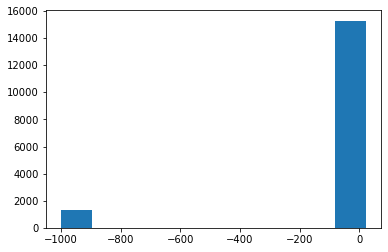

In [23]:
X_test_hierarchical_gr = X_test_hierarchical.join(df_feat[['Mean_1','Mean_2']],how='left')

X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['Mean_1']>-900) & (X_test_hierarchical_gr['Mean_2']>-900)]
y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]


X_test_hierarchical_gr = X_test_hierarchical_gr.drop(['Mean_1','Mean_2'],axis=1)
r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]


X_test_hierarchical_g = X_test_hierarchical_gr.copy()
print(X_test_hierarchical_g)
X_test_hierarchical_g[r_feat] = -999
print(X_test_hierarchical_g)

X_test_hierarchical_r = X_test_hierarchical_gr.copy()
X_test_hierarchical_r[g_feat] = -999

plt.hist(X_test_hierarchical_g['g-W2'].values)

In [24]:
Accuracy_first_layer = np.array(list_Accuracy_first_layer)
print("macro Acc first layer",np.mean(Accuracy_first_layer), np.std(Accuracy_first_layer))

Balanced_Accuracy_first_layer = np.array(list_Balanced_Accuracy_first_layer)
print("Balanced Acc first layer", np.mean(Balanced_Accuracy_first_layer), np.std(Balanced_Accuracy_first_layer))

precision_first_layer = np.array(list_precision_first_layer)
print("Precision", np.mean(precision_first_layer), np.std(precision_first_layer))

recall_first_layer = np.array(list_recall_first_layer)
print("Recall ",np.mean(recall_first_layer), np.std(recall_first_layer))

F1_first_layer = np.array(list_F1_Accuracy_first_layer)
print("F1 ", np.mean(F1_first_layer), np.std(F1_first_layer))


Accuracy_last_layer = np.array(list_Accuracy_last_layer)
print("Accuracy ",np.mean(Accuracy_last_layer), np.std(Accuracy_last_layer))

Balanced_Accuracy_last_layer = np.array(list_Balanced_Accuracy_last_layer)
print("Balanced Accuracy ",np.mean(Balanced_Accuracy_last_layer), np.std(Balanced_Accuracy_last_layer))

precision_last_layer = np.array(list_precision_last_layer)
print("Precision", np.mean(precision_last_layer), np.std(precision_last_layer))

recall_last_layer = np.array(list_recall_last_layer)
print("Recall ",np.mean(recall_last_layer), np.std(recall_last_layer))

F1_last_layer = np.array(list_F1_Accuracy_last_layer)
print("F1 ", np.mean(F1_last_layer), np.std(F1_last_layer))


array_cnf_matrix = np.array(list_cnf_matrix)

array_cnf_matrix_hier = np.array(list_cnf_matrix_hier) 
#print(array_cnf_matrix_hier)

#print(np.mean(array_cnf_matrix_hier,axis=0))
#print(np.std(array_cnf_matrix_hier,axis=0))

macro Acc first layer 0.986006216366673 0.0005714312355758167
Balanced Acc first layer 0.9812037808682437 0.001290448685784421
Precision 0.9536594163953975 0.004184818524513369
Recall  0.9812037808682437 0.001290448685784421
F1  0.9665578195062368 0.002482168110822805
Accuracy  0.834830209686398 0.0023457142603601857
Balanced Accuracy  0.7719651083057151 0.016771936767796276
Precision 0.589057827965007 0.00883604620511105
Recall  0.7719651083057151 0.016771936767796276
F1  0.6145442575689395 0.01039732132265312


Normalized confusion matrix


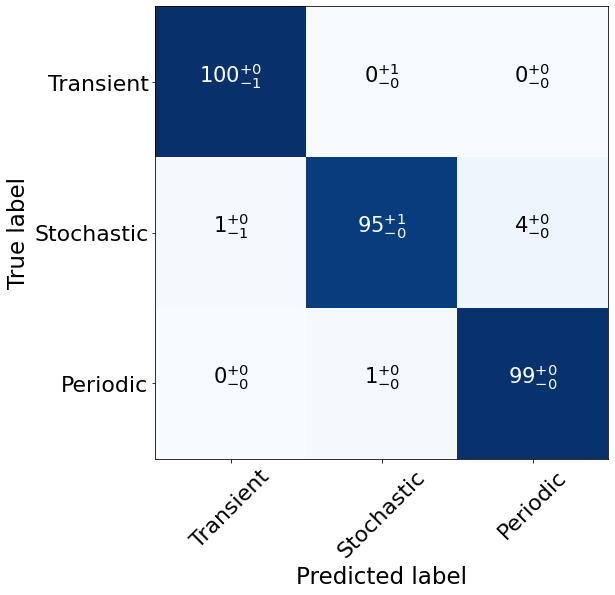

In [25]:
#hierarchical conf matrix

plot_confusion_matrix(np.median(array_cnf_matrix_hier,axis=0), np.percentile(array_cnf_matrix_hier,5,axis=0),np.percentile(array_cnf_matrix_hier,95,axis=0),cm_classes_hierachical,'final_BHRF_model/test_conf_matrix_hierarchical_original_hierarchical_classes.pdf',font=21,fig_x = 10, fig_y = 8)
plt.savefig('plots/conf_matrix_hierarchical.pdf')


Normalized confusion matrix


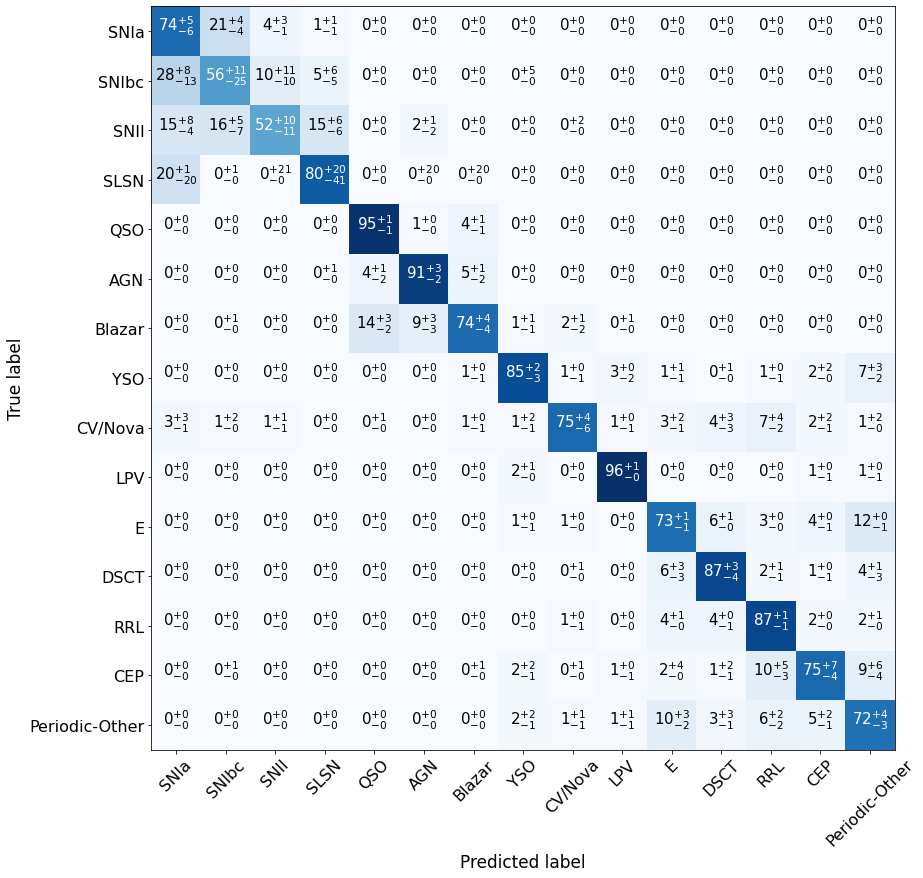

In [26]:
#multiclass conf matrix
#print(np.percentile(array_cnf_matrix,95,axis=0))
#print(np.percentile(array_cnf_matrix,50,axis=0))

plot_confusion_matrix(np.median(array_cnf_matrix,axis=0), np.percentile(array_cnf_matrix,5,axis=0),np.percentile(array_cnf_matrix,95,axis=0),label_order, 'final_BHRF_model/test_conf_matrix_multiclass_original_hierarchical_classes.pdf',font=15,fig_x = 20, fig_y = 12)
plt.savefig('plots/conf_matrix_multiclass.pdf')


In [27]:
#function to create plots for each class

def plot_accuracy_1class(bins, gr_array, g_array, r_array, gr_nsamp, g_nsamp, r_nsamp,label,ax = None, xlabel = True, ylabel = True, xlabel_name ='average magnitude',xlimit=(13, 21),lowper=5,highper=95,nsam_perbin=10):
    ax = ax or plt.gca()
    
    
    mask = (gr_nsamp<nsam_perbin)
    gr_array[mask] = np.nan
    
    gr_median = np.nanmedian(gr_array,axis=0)
    gr_low = np.nanpercentile(gr_array,lowper,axis=0)
    gr_high = np.nanpercentile(gr_array,highper,axis=0)
    
    gr_n = np.where(gr_median>-1)
    
    gr_median = gr_median[gr_n[0]]
    gr_low = gr_low[gr_n[0]]
    gr_high = gr_high[gr_n[0]]
    gr_bins = bins[gr_n[0]]
    
    ax.plot(gr_bins,gr_median,'k>-',label=r'g+r')
    ax.fill_between(gr_bins, gr_low, gr_high,alpha=0.2,  facecolor='black')

    mask = (g_nsamp<nsam_perbin)
    g_array[mask] = np.nan
    
    g_median = np.nanmedian(g_array,axis=0)
    g_low = np.nanpercentile(g_array,lowper,axis=0)
    g_high = np.nanpercentile(g_array,highper,axis=0)
    
    g_n = np.where(g_median>-1)
    g_median = g_median[g_n[0]]
    g_low = g_low[g_n[0]]
    g_high = g_high[g_n[0]]
    g_bins = bins[g_n[0]]
    
    
    ax.plot(g_bins,g_median,color='#56E03A',marker='o',linestyle='-',label=r'g')
    ax.fill_between(g_bins, g_low, g_high,alpha=0.2,  facecolor='#56E03A')
    
    mask = (r_nsamp<nsam_perbin)
    r_array[mask] = np.nan
    
    r_median = np.nanmedian(r_array,axis=0)
    r_low = np.nanpercentile(r_array,lowper,axis=0)
    r_high = np.nanpercentile(r_array,highper,axis=0)
    
    r_n = np.where(r_median>-1)
    
    r_median = r_median[r_n[0]]
    r_low = r_low[r_n[0]]
    r_high = r_high[r_n[0]]
    r_bins = bins[r_n[0]]
    
    ax.plot(r_bins,r_median,color='#D42F4B',marker='s',linestyle='-',label=r'r')
    ax.fill_between(r_bins, r_low, r_high,alpha=0.2,  facecolor='#D42F4B')
    
    ax.set_title(label)
    ax.set_ylim(0,1.1)
    ax.set_xlim(xlimit)
    plt.legend(loc= 'lower right',fontsize=14)
    if xlabel: ax.set_xlabel(xlabel_name,fontsize=12)
    if ylabel: ax.set_ylabel('Recall',fontsize=12)
    
    

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

(20, 18)
(18,)


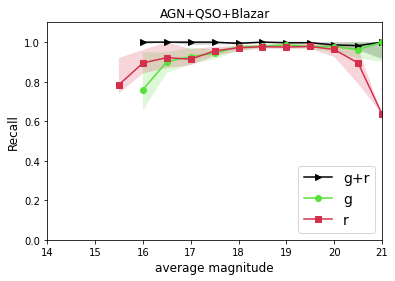

In [28]:
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_AQB, array_acc_mag_gband_AQB, array_acc_mag_rband_AQB, array_nsamp_mag_grband_AQB, array_nsamp_mag_gband_AQB, array_nsamp_mag_rband_AQB,'AGN+QSO+Blazar',xlimit=(14,21))
plt.savefig('plots/recall_agn_qso_blazar_for_mag.pdf',bbox_inches='tight')
print((array_acc_mag_grband_AQB).shape)
print(bins_mag_r.shape)

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

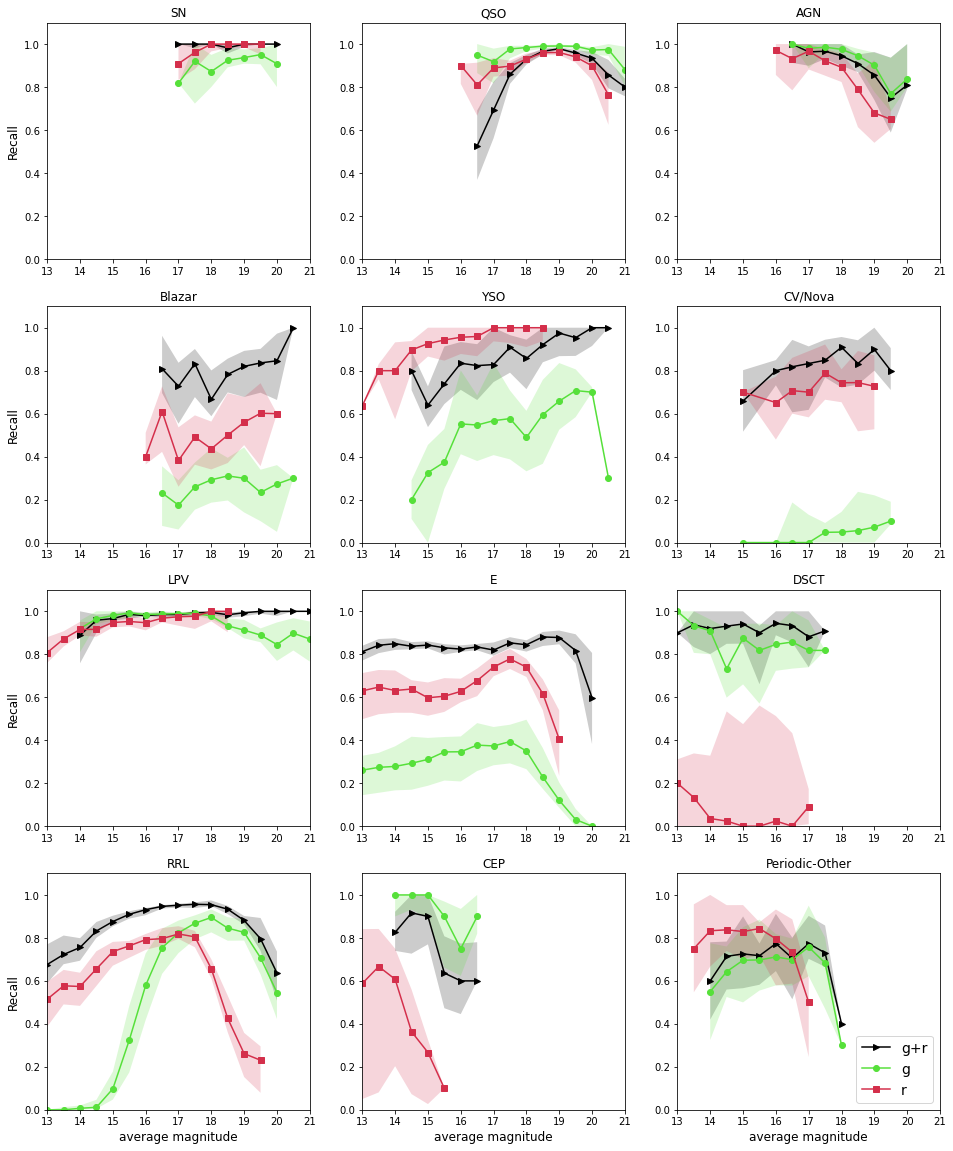

In [29]:
fig, axarr = plt.subplots(4, 3, figsize=(16,20))

plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_transients, array_acc_mag_gband_transients, array_acc_mag_rband_transients, array_nsamp_mag_grband_transients, array_nsamp_mag_gband_transients, array_nsamp_mag_rband_transients,'SN',ax=axarr[0,0],xlabel=False )



plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_QSO, array_acc_mag_gband_QSO, array_acc_mag_rband_QSO, array_nsamp_mag_grband_QSO, array_nsamp_mag_gband_QSO, array_nsamp_mag_rband_QSO,'QSO', ax=axarr[0,1],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_AGN, array_acc_mag_gband_AGN, array_acc_mag_rband_AGN, array_nsamp_mag_grband_AGN, array_nsamp_mag_gband_AGN, array_nsamp_mag_rband_AGN,'AGN', ax=axarr[0,2],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Blazar, array_acc_mag_gband_Blazar, array_acc_mag_rband_Blazar, array_nsamp_mag_grband_Blazar, array_nsamp_mag_gband_Blazar, array_nsamp_mag_rband_Blazar,'Blazar', ax=axarr[1,0],xlabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_YSO, array_acc_mag_gband_YSO, array_acc_mag_rband_YSO, array_nsamp_mag_grband_YSO, array_nsamp_mag_gband_YSO, array_nsamp_mag_rband_YSO,'YSO', ax=axarr[1,1],ylabel=False,xlabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_CV, array_acc_mag_gband_CV, array_acc_mag_rband_CV, array_nsamp_mag_grband_CV, array_nsamp_mag_gband_CV, array_nsamp_mag_rband_CV,'CV/Nova',  ax=axarr[1,2],ylabel=False,xlabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_LPV, array_acc_mag_gband_LPV, array_acc_mag_rband_LPV, array_nsamp_mag_grband_LPV, array_nsamp_mag_gband_LPV, array_nsamp_mag_rband_LPV,'LPV',  ax=axarr[2,0],xlabel=False)





plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_EB, array_acc_mag_gband_EB, array_acc_mag_rband_EB, array_nsamp_mag_grband_EB, array_nsamp_mag_gband_EB, array_nsamp_mag_rband_EB,'E', ax=axarr[2,1],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_DSCT, array_acc_mag_gband_DSCT, array_acc_mag_rband_DSCT, array_nsamp_mag_grband_DSCT, array_nsamp_mag_gband_DSCT, array_nsamp_mag_rband_DSCT,'DSCT', ax=axarr[2,2],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_RRL, array_acc_mag_gband_RRL, array_acc_mag_rband_RRL, array_nsamp_mag_grband_RRL, array_nsamp_mag_gband_RRL, array_nsamp_mag_rband_RRL,'RRL', ax=axarr[3,0] )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Ceph, array_acc_mag_gband_Ceph, array_acc_mag_rband_Ceph, array_nsamp_mag_grband_Ceph, array_nsamp_mag_gband_Ceph, array_nsamp_mag_rband_Ceph,'CEP', ax=axarr[3,1],ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Other, array_acc_mag_gband_Other, array_acc_mag_rband_Other, array_nsamp_mag_grband_Other, array_nsamp_mag_gband_Other, array_nsamp_mag_rband_Other,'Periodic-Other', ax=axarr[3,2],ylabel=False)

plt.savefig('plots/recall_all_for_mag.pdf',bbox_inches='tight')



In [30]:
def plot_accuracy_1class_nsamps(bins_gr, bins_g, bins_r, gr_array, g_array, r_array, gr_nsamp, g_nsamp, r_nsamp,label,ax = None, xlabel = True, ylabel = True, xlabel_name =r'$\# \mathrm{detections}$',xlimit=(5,150),lowper=5,highper=95,nsam_perbin=10):
    
    ax = ax or plt.gca()
    #print(bins)
    #print(gr_array)
    
    mask = (gr_nsamp<nsam_perbin)
    gr_array[mask] = np.nan
    
    gr_median = np.nanmedian(gr_array,axis=0)
    gr_low = np.nanpercentile(gr_array,lowper,axis=0)
    gr_high = np.nanpercentile(gr_array,highper,axis=0)
    
    gr_n = np.where(gr_median>-1)
    
    gr_median = gr_median[gr_n[0]]
    gr_low = gr_low[gr_n[0]]
    gr_high = gr_high[gr_n[0]]
    gr_bins = bins_gr[gr_n[0]]
    
    ax.plot(gr_bins,gr_median,'k>-',label=r'g+r')
    ax.fill_between(gr_bins, gr_low, gr_high,alpha=0.2,  facecolor='black')

    mask = (g_nsamp<nsam_perbin)
    g_array[mask] = np.nan
    
    g_median = np.nanmedian(g_array,axis=0)
    g_low = np.nanpercentile(g_array,lowper,axis=0)
    g_high = np.nanpercentile(g_array,highper,axis=0)
    
    g_n = np.where(g_median>-1)
    g_median = g_median[g_n[0]]
    g_low = g_low[g_n[0]]
    g_high = g_high[g_n[0]]
    g_bins = bins_g[g_n[0]]
    
    
    ax.plot(g_bins,g_median,color='#56E03A',marker='o',linestyle='-',label=r'g')
    ax.fill_between(g_bins, g_low, g_high,alpha=0.2,  facecolor='#56E03A')
    
    mask = (r_nsamp<nsam_perbin)
    r_array[mask] = np.nan
    
    r_median = np.nanmedian(r_array,axis=0)
    r_low = np.nanpercentile(r_array,lowper,axis=0)
    r_high = np.nanpercentile(r_array,highper,axis=0)
    
    r_n = np.where(r_median>-1)
    
    r_median = r_median[r_n[0]]
    r_low = r_low[r_n[0]]
    r_high = r_high[r_n[0]]
    r_bins = bins_r[r_n[0]]
    
    ax.plot(r_bins,r_median,color='#D42F4B',marker='s',linestyle='-',label=r'r')
    ax.fill_between(r_bins, r_low, r_high,alpha=0.2,  facecolor='#D42F4B')
    
    ax.set_title(label)
    ax.set_ylim(0,1.1)
    ax.set_xlim(xlimit)
    ax.set_xscale('log')
    plt.legend(loc='lower right', fontsize=14)
    if xlabel: ax.set_xlabel(xlabel_name,fontsize=12)
    if ylabel: ax.set_ylabel('Recall',fontsize=12)
    
    

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

No handles with labels found to put in legend.
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/pyt

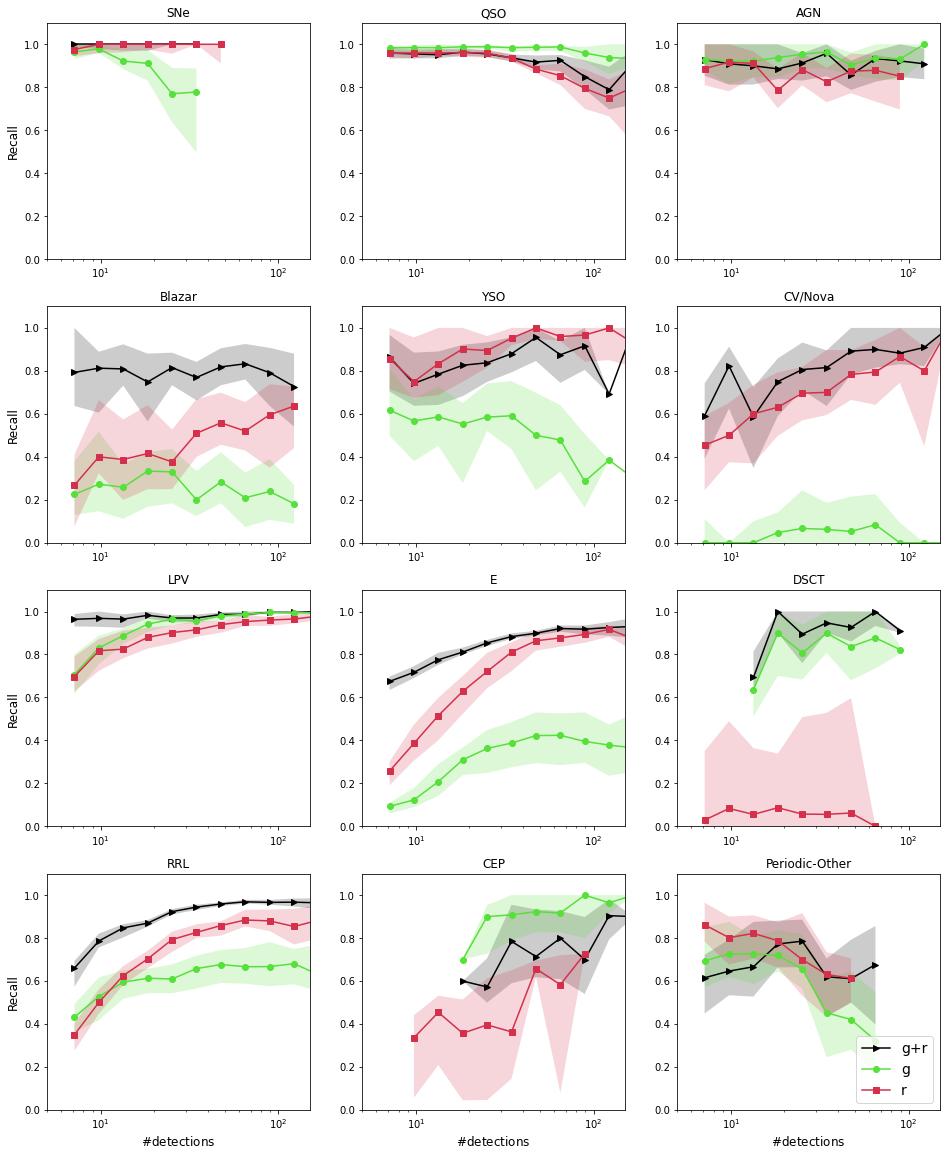

In [31]:
fig2, axarr2 = plt.subplots(4, 3, figsize=(16,20))
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_transients, array_acc_nsamp_gband_transients, array_acc_nsamp_rband_transients, array_nsamp_nsamp_grband_transients, array_nsamp_nsamp_gband_transients, array_nsamp_nsamp_rband_transients,'SNe',ax=axarr2[0,0],xlabel=False )


plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_QSO, array_acc_nsamp_gband_QSO, array_acc_nsamp_rband_QSO, array_nsamp_nsamp_grband_QSO, array_nsamp_nsamp_gband_QSO, array_nsamp_nsamp_rband_QSO,'QSO', ax=axarr2[0,1],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_AGN, array_acc_nsamp_gband_AGN, array_acc_nsamp_rband_AGN, array_nsamp_nsamp_grband_AGN, array_nsamp_nsamp_gband_AGN, array_nsamp_nsamp_rband_AGN,'AGN', ax=axarr2[0,2],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Blazar, array_acc_nsamp_gband_Blazar, array_acc_nsamp_rband_Blazar, array_nsamp_nsamp_grband_Blazar, array_nsamp_nsamp_gband_Blazar, array_nsamp_nsamp_rband_Blazar,'Blazar', ax=axarr2[1,0],xlabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_YSO, array_acc_nsamp_gband_YSO, array_acc_nsamp_rband_YSO, array_nsamp_nsamp_grband_YSO, array_nsamp_nsamp_gband_YSO, array_nsamp_nsamp_rband_YSO,'YSO', ax=axarr2[1,1],ylabel=False,xlabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_CV, array_acc_nsamp_gband_CV, array_acc_nsamp_rband_CV, array_nsamp_nsamp_grband_CV, array_nsamp_nsamp_gband_CV, array_nsamp_nsamp_rband_CV,'CV/Nova', ax=axarr2[1,2],ylabel=False,xlabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_LPV, array_acc_nsamp_gband_LPV, array_acc_nsamp_rband_LPV, array_nsamp_nsamp_grband_LPV, array_nsamp_nsamp_gband_LPV, array_nsamp_nsamp_rband_LPV,'LPV', ax=axarr2[2,0],xlabel=False )



plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_EB, array_acc_nsamp_gband_EB, array_acc_nsamp_rband_EB, array_nsamp_nsamp_grband_EB, array_nsamp_nsamp_gband_EB, array_nsamp_nsamp_rband_EB,'E', ax=axarr2[2,1],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_DSCT, array_acc_nsamp_gband_DSCT, array_acc_nsamp_rband_DSCT, array_nsamp_nsamp_grband_DSCT, array_nsamp_nsamp_gband_DSCT, array_nsamp_nsamp_rband_DSCT,'DSCT', ax=axarr2[2,2],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_RRL, array_acc_nsamp_gband_RRL, array_acc_nsamp_rband_RRL, array_nsamp_nsamp_grband_RRL, array_nsamp_nsamp_gband_RRL, array_nsamp_nsamp_rband_RRL,'RRL', ax=axarr2[3,0] )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Ceph, array_acc_nsamp_gband_Ceph, array_acc_nsamp_rband_Ceph, array_nsamp_nsamp_grband_Ceph, array_nsamp_nsamp_gband_Ceph, array_nsamp_nsamp_rband_Ceph,'CEP', ax=axarr2[3,1],ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Other, array_acc_nsamp_gband_Other, array_acc_nsamp_rband_Other, array_nsamp_nsamp_grband_Other, array_nsamp_nsamp_gband_Other, array_nsamp_nsamp_rband_Other,'Periodic-Other', ax=axarr2[3,2],ylabel=False)



plt.savefig('plots/recall_all_for_ndet.pdf',bbox_inches='tight')

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

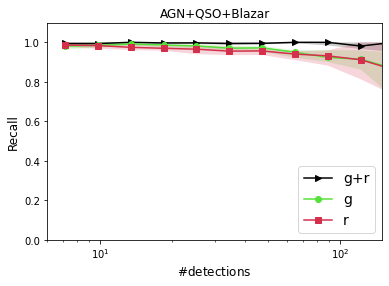

In [32]:
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_AQB, array_acc_nsamp_gband_AQB, array_acc_nsamp_rband_AQB, array_nsamp_nsamp_grband_AQB, array_nsamp_nsamp_gband_AQB, array_nsamp_nsamp_rband_AQB,'AGN+QSO+Blazar',xlimit=(6,150))

plt.savefig('plots/recall_agn_qso_blazar_for_ndet.pdf',bbox_inches='tight')